# Question 3: Investigating Topology in Node-Based Classification Using GNNs

In this section, we will explore the impact of graph topology on node-based classification using GNNs. The experiments will focus on analyzing different topological measures, visualizing their distributions, and evaluating GCN performance on 2 graphs with different topologies.

In [1]:
import json
import torch
import os
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from graph_ricci_curvature import GraphRicciCurvature

## Helper function and code for loading data

In [2]:
G1_TRAIN_FILE_NAME = "q3_G1_train.json"
G1_EVAL_FILE_NAME = "q3_G1_eval.json"

G1_TRAIN_DATA_PATH = os.path.join("data",G1_TRAIN_FILE_NAME)
G1_EVAL_DATA_PATH = os.path.join("data",G1_EVAL_FILE_NAME)

G2_TRAIN_FILE_NAME = "q3_G2_train.json"
G2_EVAL_FILE_NAME = "q3_G2_eval.json"

G2_TRAIN_DATA_PATH = os.path.join("data",G2_TRAIN_FILE_NAME)
G2_EVAL_DATA_PATH = os.path.join("data",G2_EVAL_FILE_NAME)

In [3]:
# Functions to load the data
def create_Adj_matrix(N, edge_index):
    """Creates the adjacency matrix"""
    A = torch.zeros((N, N), dtype=torch.float)
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    return A

def read_json_data(file_path, has_label=True):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    if not type(data) == list:
        item = data
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        return (X,A,y)

    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        
        graph_data.append((X,A,y))
    
    return graph_data


## Question 3.1 - Analyzing the Graphs


### Q3.1.b Visualizing and Comparing Topological and Geometric Measures of Two Graphs

Implement the following three functions to visualize and compare structural properties of two given graphs:

- `plot_node_degree_distribution_two_graphs`
- `plot_betweenness_centrality_distribution_two_graphs`
- `plot_ollivier_ricci_curvature_distribution_two_graphs`




In [ ]:
def compute_node_degree(A):
    """
    Given an adjacency matrix A of shape (N, N),
    return the degree (row sum) for each of the N nodes.
    """
    degrees = A.sum(dim=1)  # sum across columns
    return degrees

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


def plot_node_degree_distribution_two_graphs(A1, A2, dataset_name='Training', save=False, plot_name=""):
    """
    Plots the node degree distributions of two graphs
    with adjacency matrices A1 and A2 (each of shape (N, N))
    in a single figure.
    Params: 
    - A1 (torch.Tensor): adjacency matrix of graph 1
    - A2 (torch.Tensor): adjacency matrix of graph 2
    - dataset_name (str): name of the dataset
    - save (bool): whether to save the plot
    - plot_name (str): name of the plot to save
    """
    plt.figure(figsize=(15, 15))
    node_deg_dist_G1 = compute_node_degree(A1)
    node_deg_dist_G2 = compute_node_degree(A2)

    # ensure all bins have equal width
    G1_bins = np.unique(node_deg_dist_G1)
    G2_bins = np.unique(node_deg_dist_G2)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.hist(x=node_deg_dist_G1, color="cornflowerblue", label="Graph 1", edgecolor='navy', alpha=0.6, bins=G1_bins)
    plt.hist(x=node_deg_dist_G2, color="orchid", label="Graph 2", edgecolor='purple', alpha=0.6, bins=G2_bins)

    plt.grid(True, alpha=0.5)

    plt.xlabel('Degree')
    plt.ylabel('Node Count')
    plt.title(f'Comparison of Node Degree Distributions\n{dataset_name} Dataset')
    plt.legend()
    if save:
        fig_name = f"images/Q3/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

In [ ]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def compute_betweenness_centrality(A):
    """
    Calculate the betweenness centrality of each node in the graph
    defined by the given adjacency matrix A.
    Params:
        - A (torch.Tensor): Adjacency matrix of shape (N, N)
    Returns:
        - betweenness_centrality (np.array): betweenness centrality
                                            values of each graph node
    """
    G = nx.from_numpy_array(A.numpy())
    betweenness_centrality = nx.betweenness_centrality(G)
    betweenness_centrality = np.array(list(betweenness_centrality.values()))
    return betweenness_centrality

def plot_betweenness_distribution_two_graphs(A1, A2, dataset_name='Training', save=False, plot_name=""):
    """
    Plots the betweenness centrality distributions of two graphs
    defined by adjacency matrices A1 and A2 (each of shape (N, N)) 
    in a single figure.
    Params:
        -   A1 (torch.Tensor): Adjacency matrix of graph 1
        -   A2 (torch.Tensor): Adjacency matrix of graph 2
        -   dataset_name (str): Name of the dataset
        -   save (bool): Whether to save the plot
        -   plot_name (str): Name of the plot to save
    """
    plt.figure(figsize=(15, 15))
    betweenness_G1 = compute_betweenness_centrality(A1)
    betweenness_G2 = compute_betweenness_centrality(A2)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.hist(x=betweenness_G1, color="cornflowerblue", label="Graph 1", edgecolor='navy', alpha=0.6)
    plt.hist(x=betweenness_G2, color="orchid", label="Graph 2", edgecolor='purple', alpha=0.6)

    plt.grid(True, alpha=0.5)

    plt.xlabel('Betweenness Centrality')
    plt.ylabel('Node Count')
    plt.title(f'Comparison of Betweenness Centrality Distributions\n{dataset_name} Dataset')
    plt.legend()
    if save:
        fig_name = f"images/Q3/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

In [ ]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def plot_ricci_curvature_distribution_two_graphs(A1, A2, dataset_name='Training', save=False, plot_name=""):
    """
    Plots the Ollivier-Ricci curvature distributions for two graphs
    defined by adjacency matrices A1 and A2 (PyTorch tensors).
    Params_
        - A1, A2 (torch.Tensor): Adjacency matrices for two undirected graphs (NxN).
        - dataset_name (str): Name of the dataset (for plot title).
        - save (bool): Whether to save the plot as a PDF file.
        - plot_name (str): Name of the plot file if saved.
    """
    # 1) Convert PyTorch adjacency -> NumPy -> NetworkX Graph
    A1_np = A1.numpy()
    A2_np = A2.numpy()

    G1 = nx.from_numpy_array(A1_np)
    G2 = nx.from_numpy_array(A2_np)

    # 2) Instantiate OllivierRicci object for each graph
    ricci_calculator_G1 = GraphRicciCurvature(G1)
    ricci_calculator_G2 = GraphRicciCurvature(G2)

    # 3) Compute the Ricci curvature
    curvatures1 = ricci_calculator_G1.compute_ricci_curvatures()
    curvatures2 = ricci_calculator_G2.compute_ricci_curvatures()

    # After computation, the Ricci curvature for each edge is stored in G[u][v]["ricciCurvature"]

    # 4) Gather edge-level Ricci curvature values
    ricci_values_G1 = []
    for (u, v), val in curvatures1.items():
        ricci_values_G1.append(val)

    ricci_values_G2 = []
    for (u, v), val in curvatures2.items():
        ricci_values_G2.append(val)

    # Continue with plotting ...

    plt.figure(figsize=(15, 15))
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.hist(x=ricci_values_G1, color="cornflowerblue", label="Graph 1", edgecolor='navy', alpha=0.6)
    plt.hist(x=ricci_values_G2, color="orchid", label="Graph 2", edgecolor='purple', alpha=0.6)

    plt.grid(True, alpha=0.5)

    plt.xlabel('Ricci Curvature')
    plt.ylabel('Edge Count')
    plt.title(f'Comparison of Oliver-Ricci Curvature\n{dataset_name} Dataset')
    plt.legend()
    if save:
        fig_name = f"images/Q3/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

In [7]:
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

<Figure size 1500x1500 with 0 Axes>

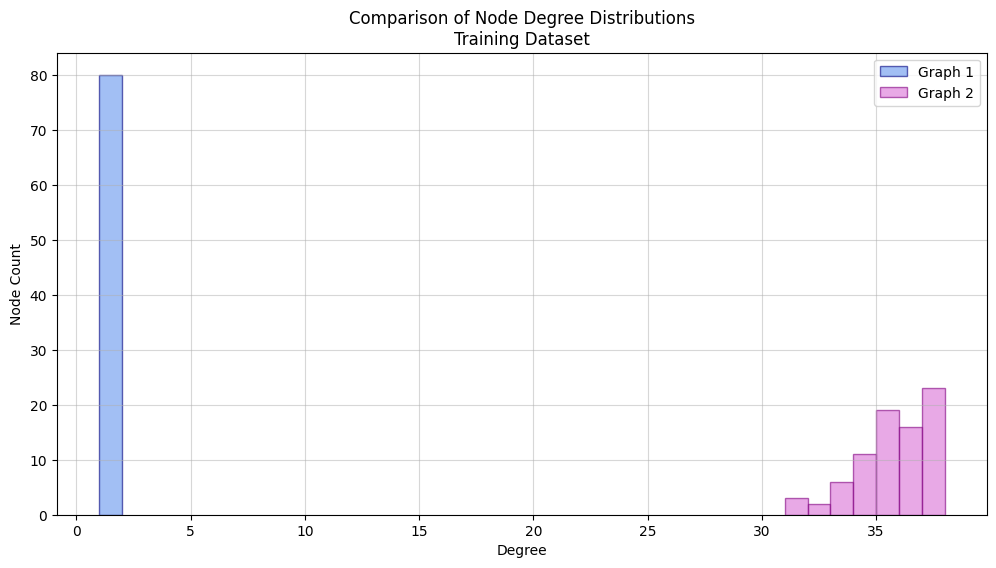

<Figure size 1500x1500 with 0 Axes>

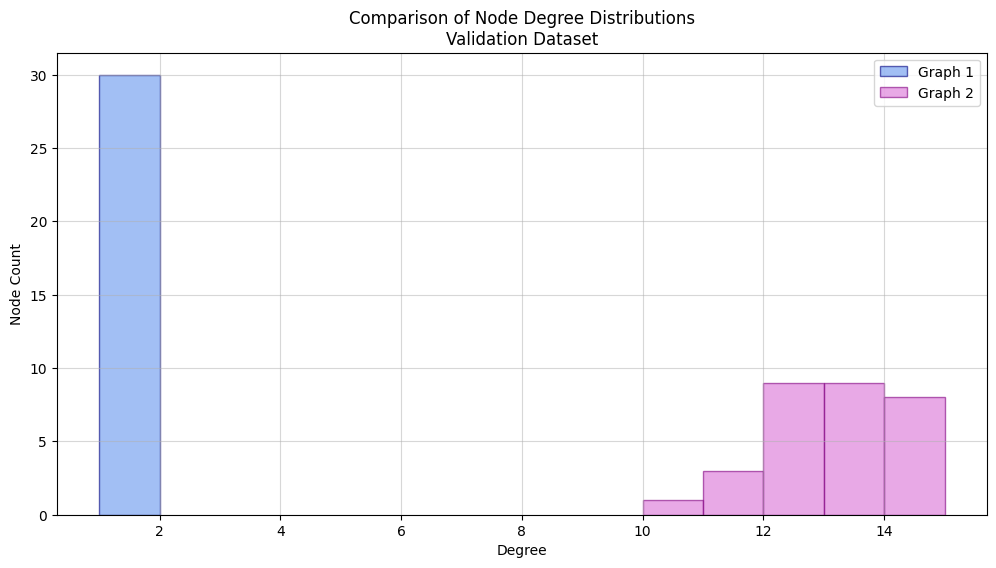

In [ ]:
plot_node_degree_distribution_two_graphs(G1_train[1], G2_train[1], dataset_name='Training') #, save=True, plot_name="node_deg_dist_training")
plot_node_degree_distribution_two_graphs(G1_eval[1], G2_eval[1], dataset_name='Validation') #, save=True, plot_name="node_deg_dist_eval")

<Figure size 1500x1500 with 0 Axes>

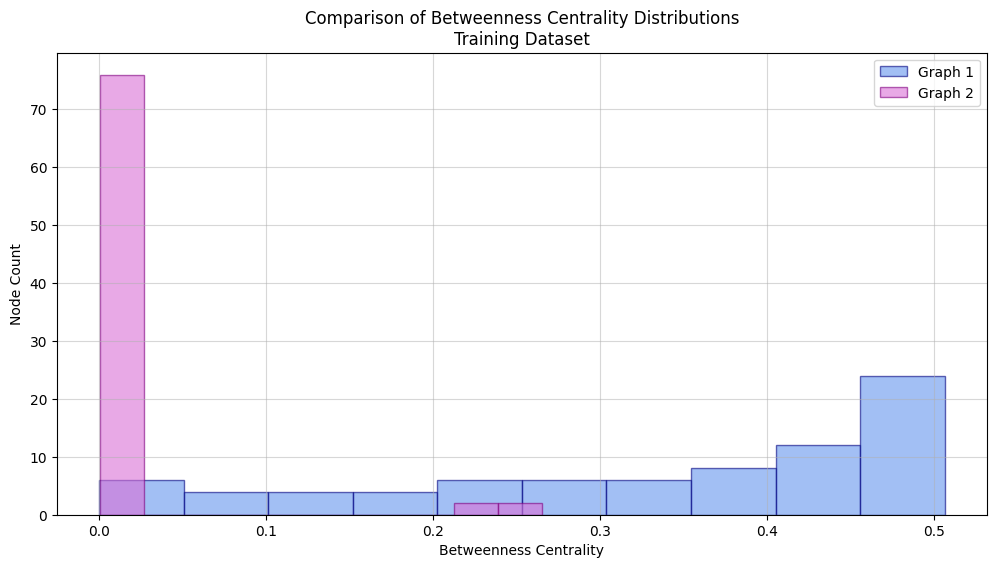

<Figure size 1500x1500 with 0 Axes>

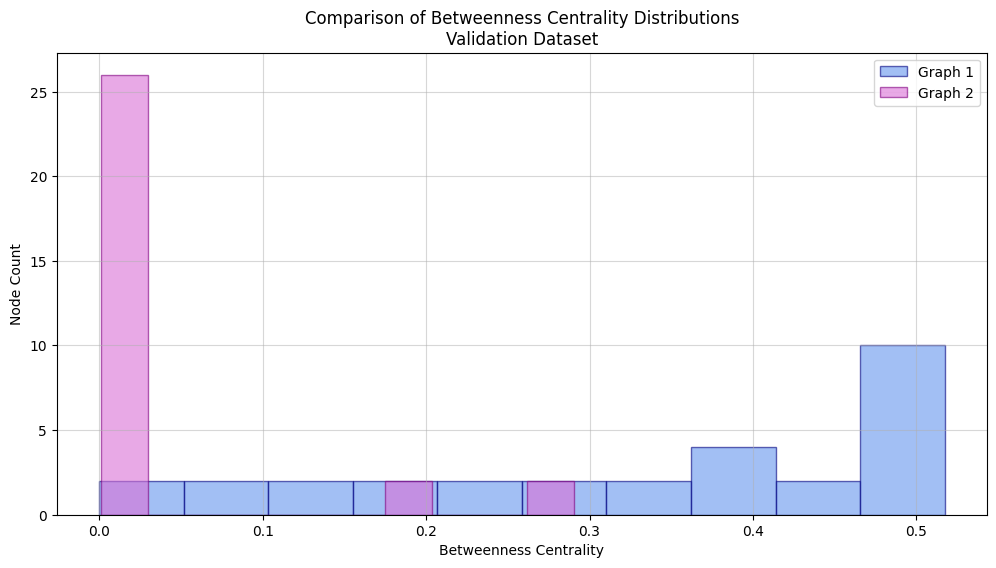

In [ ]:
plot_betweenness_distribution_two_graphs(G1_train[1], G2_train[1], dataset_name='Training') #, save=True, plot_name="betweenness_training")
plot_betweenness_distribution_two_graphs(G1_eval[1], G2_eval[1], dataset_name='Validation') #, save=True, plot_name="betweenness_eval")

<Figure size 1500x1500 with 0 Axes>

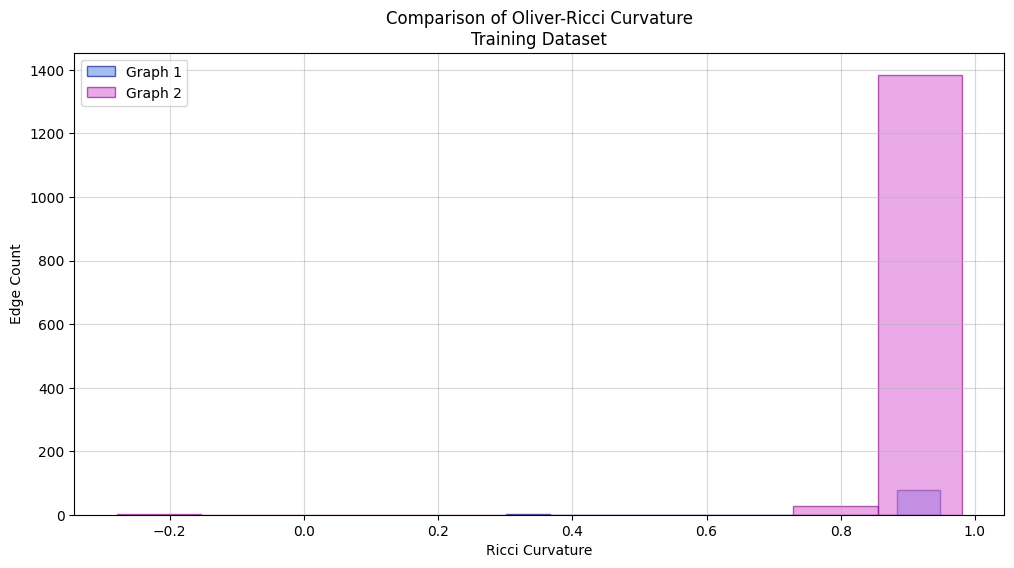

<Figure size 1500x1500 with 0 Axes>

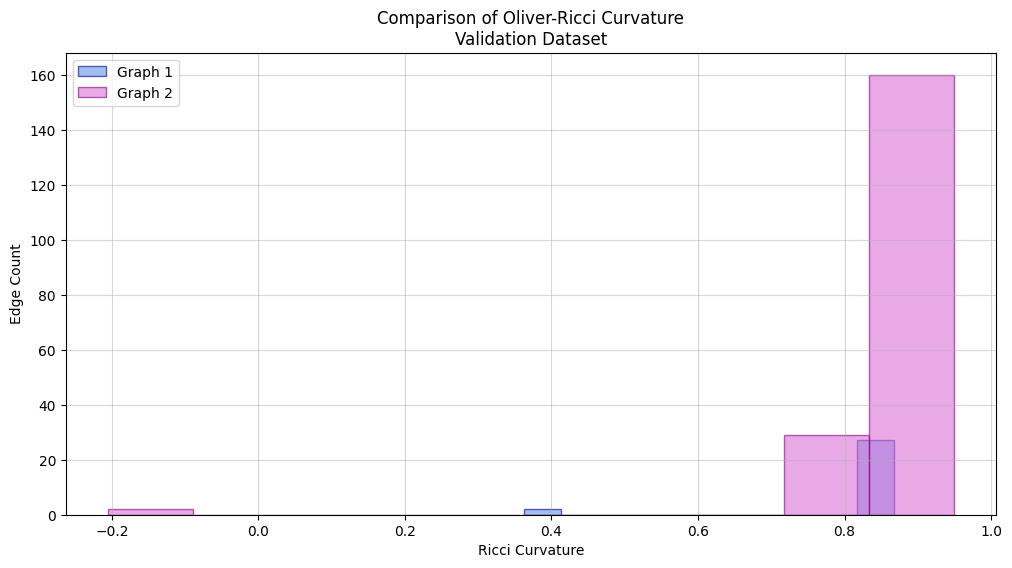

In [ ]:
plot_ricci_curvature_distribution_two_graphs(G1_train[1], G2_train[1], dataset_name='Training') #, save=True, plot_name="ricci_curvature_training")
plot_ricci_curvature_distribution_two_graphs(G1_eval[1], G2_eval[1], dataset_name='Validation') #, save=True, plot_name="ricci_curvature_eval")

### Q3.1.c Visualizing the Graphs

Implement the `plot_graph` function to generate visual representations of both graphs. Ensure that the plots are clear and well-formatted.


In [ ]:
def get_nodes_style(A, y, edgecolors = {0: 'blue', 1: 'red'}):
    """
    Get the color of each node based on its class type.
    Params:
        - A (torch.Tensor): adjacency matrix 
        - y (torch.Tensor: node labels
        - edgecolors (dict): color mapping for each class
    Returns:
        - node_edgecolors (list): list of colors for each node
    """
    node_edgecolors = []
    classes = {0:0, 1:0}
    # enumerate original graph based on chosen size and shift
    for i,_ in enumerate(A):
        node_class = int(y[i])
        classes[node_class] += 1
        node_edgecolors.append(edgecolors[node_class])
    # print(f"Class 0: {classes[0]} nodes, Class 1: {classes[1]} nodes")
    return node_edgecolors

def plot_graph(A, nodecolor='cornflowerblue', highlight_classes=None, graph_name='G', save=False, plot_name=""):
    """
    Plots a graph defined by adjacency matrix A.
    Params:
        - A (torch.Tensor): Adjacency matrix of shape (N, N).
        - nodecolor (str): chosen color of graph nodes
        - highlight_classes (list): [OPTIONAL] list of classes to 
                                    differentiate nodes by edge color
        - graph_name (str): name of the graph
        - save (bool): wether to save the plot as a PDF
        - plot_name (str): name of the
    """
    plt.figure(figsize=(15, 15))
    G = nx.from_numpy_array(A.numpy())
    pos = nx.spring_layout(G, seed=0)
    if highlight_classes is not None:
        edge_colors = get_nodes_style(A, highlight_classes)
    else:
        edge_colors = nodecolor

    nx.draw_networkx_nodes(G, pos,
                            node_color=nodecolor,
                            node_size=400,
                            linewidths=2,
                            edgecolors=edge_colors)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, 
                            font_size=10,
                            clip_on=True)
    plt.title(f"Graph {graph_name}")
    plt.grid(False)
    if save:
        fig_name = f"images/Q3/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

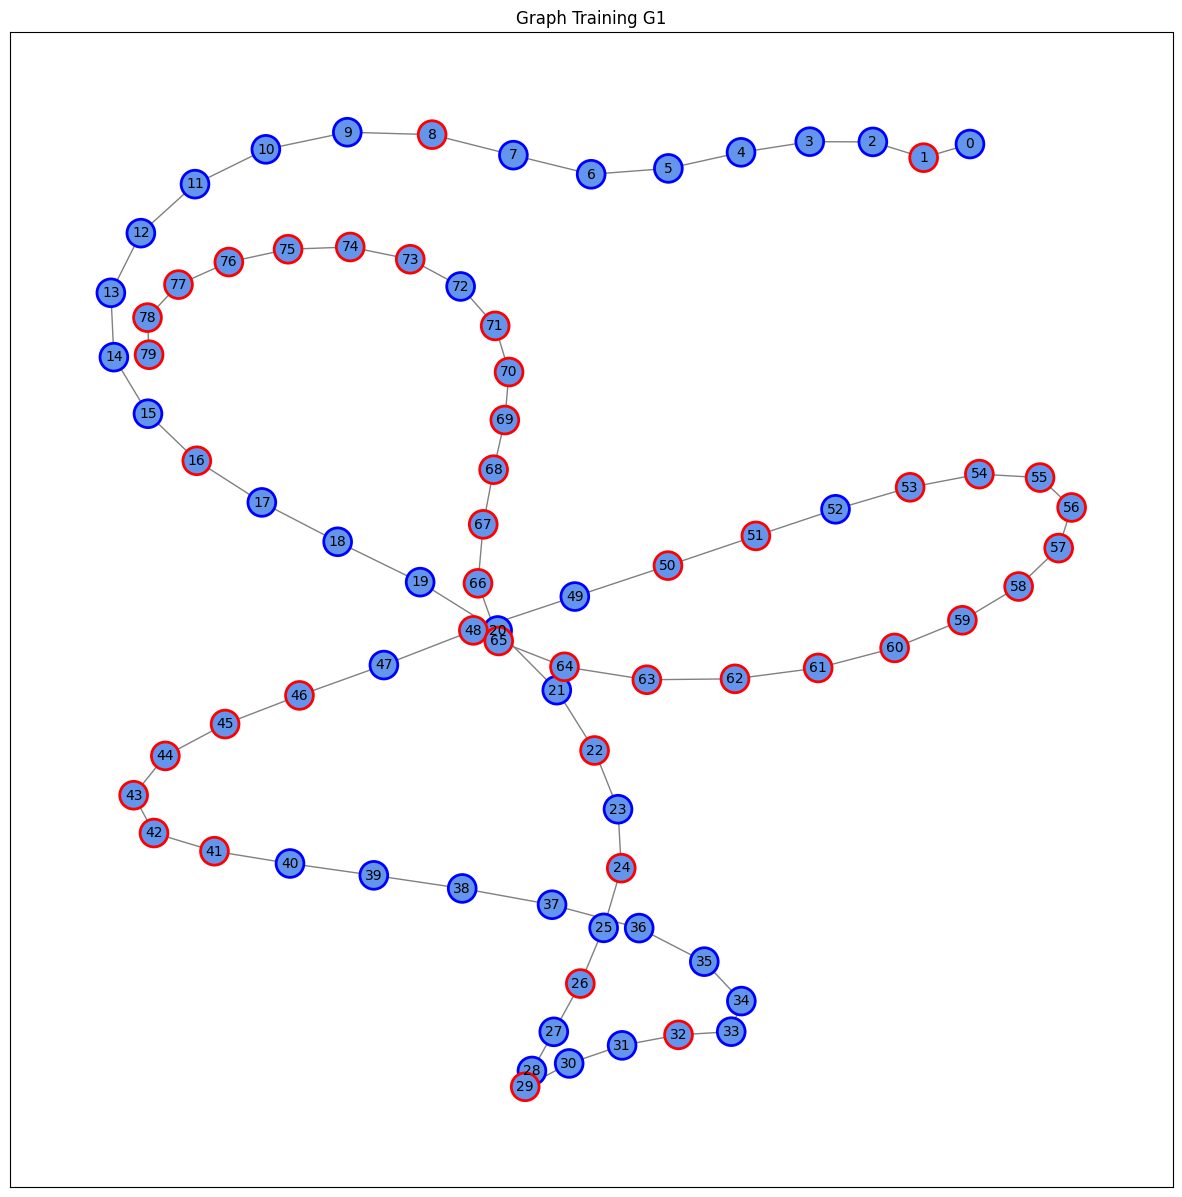

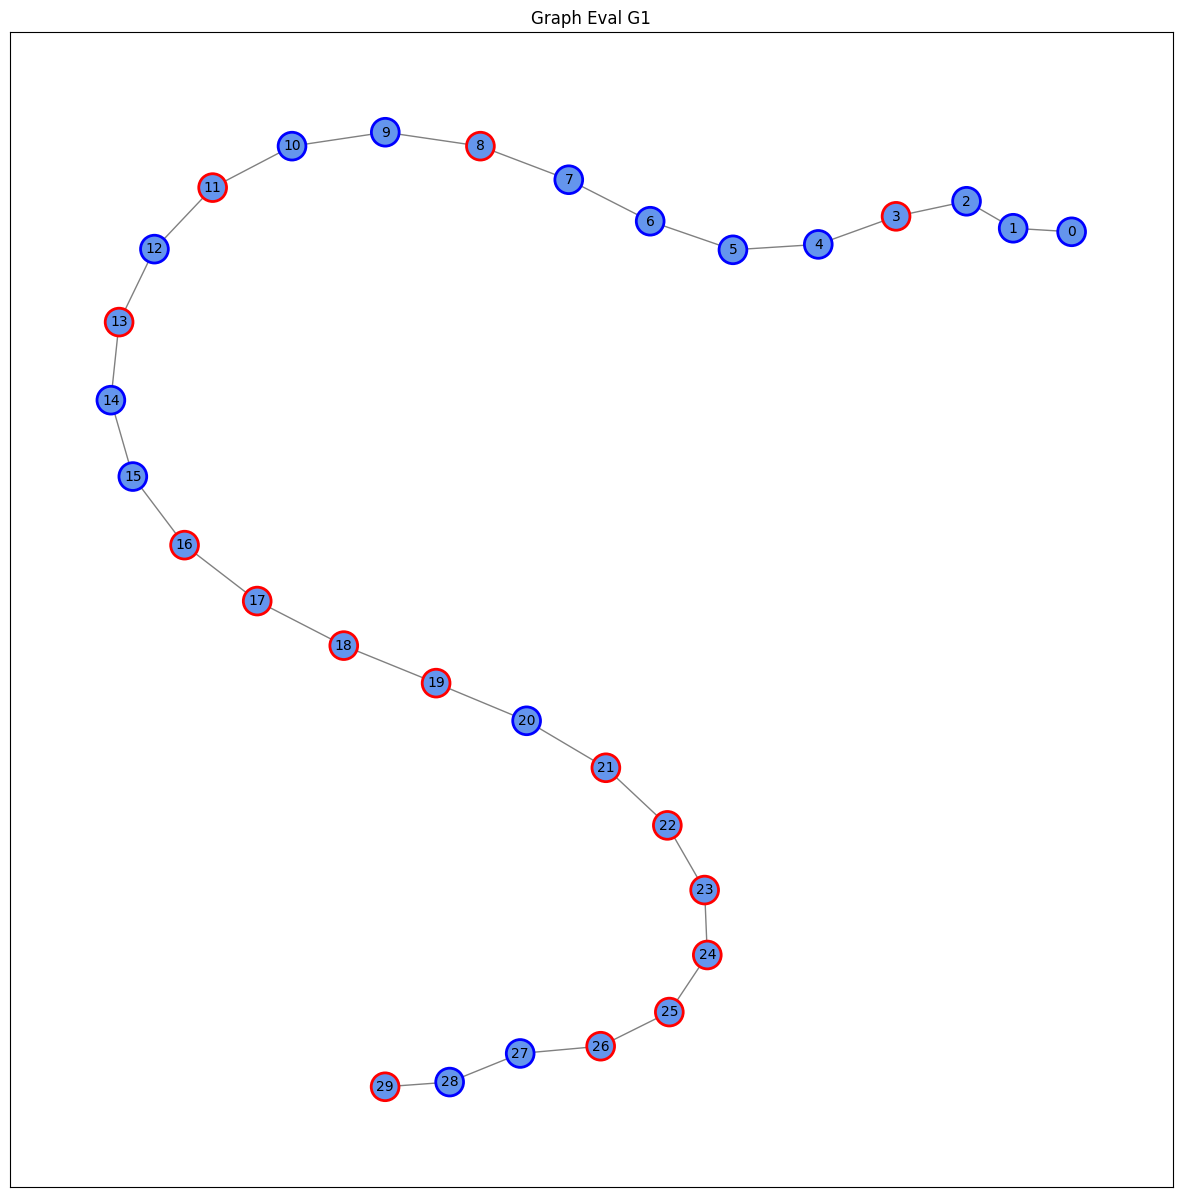

In [ ]:
plot_graph(G1_train[1], nodecolor='cornflowerblue', highlight_classes=G1_train[2], graph_name='Training G1') #, save=True, plot_name="Training_Graph_G1")
plot_graph(G1_eval[1], nodecolor='cornflowerblue', highlight_classes=G1_eval[2], graph_name='Eval G1') #, save=True, plot_name="Eval_Graph_G1")

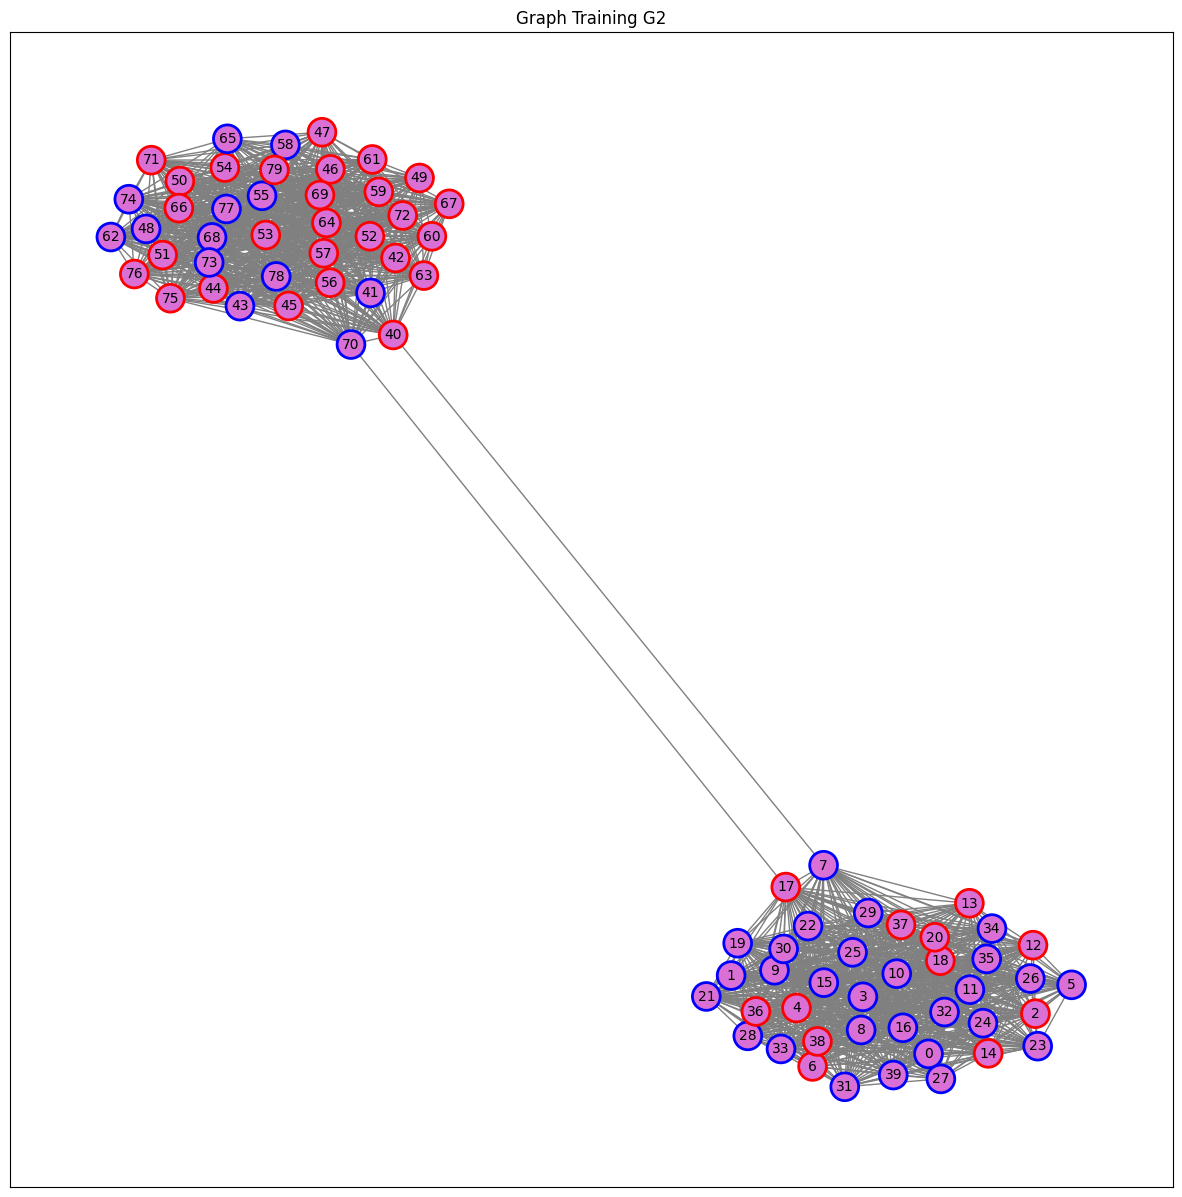

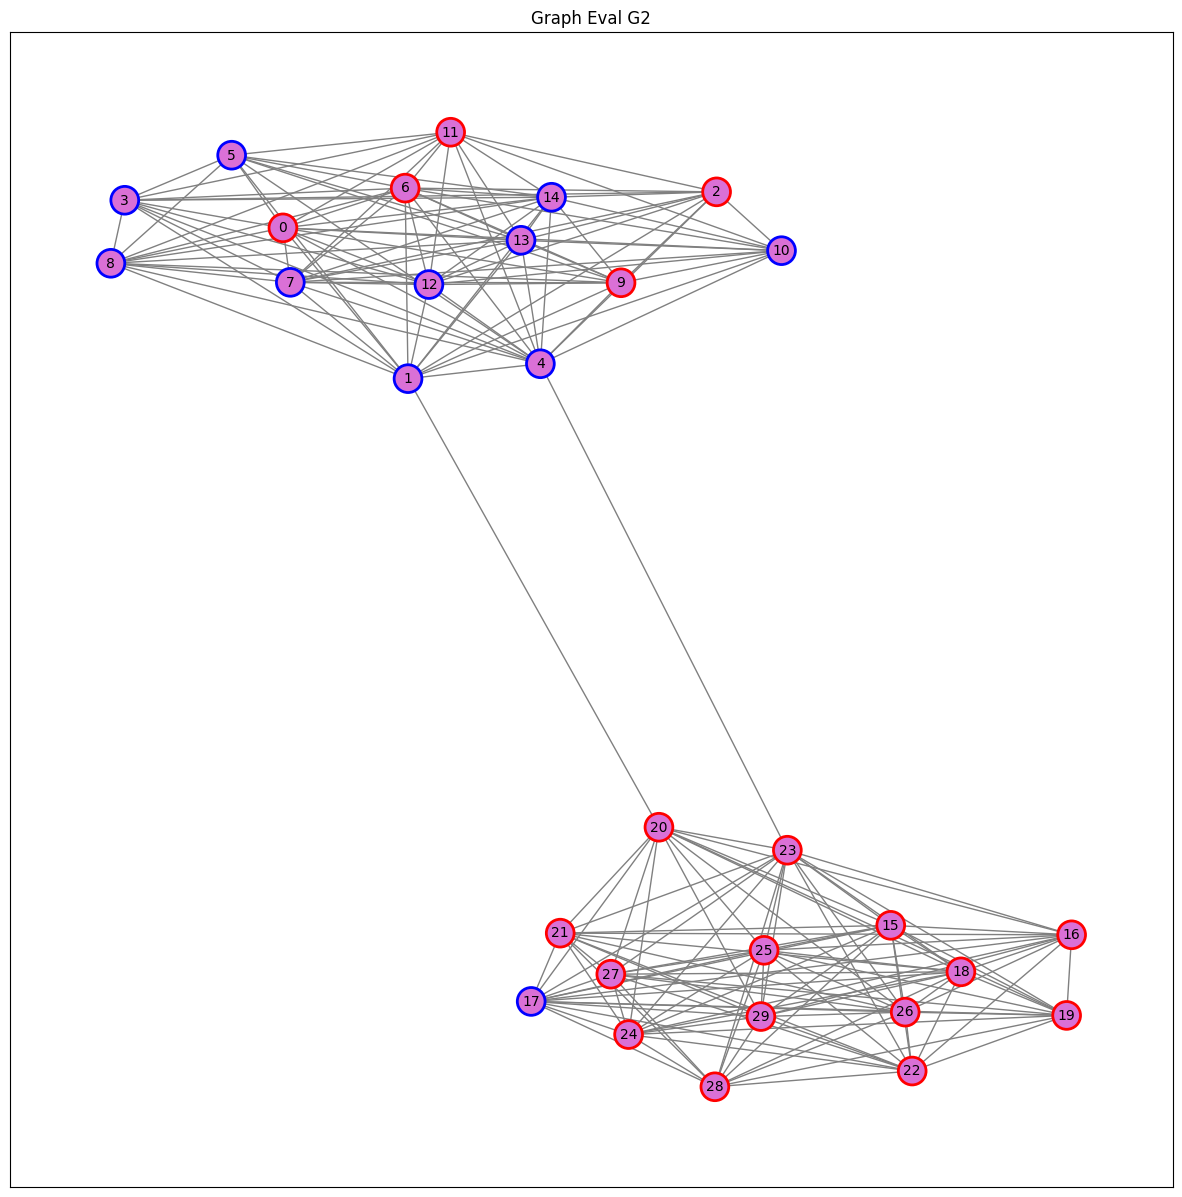

In [ ]:
plot_graph(G2_train[1], nodecolor='orchid', highlight_classes=G2_train[2], graph_name='Training G2') #, save=True, plot_name="Training_Graph_G2")
plot_graph(G2_eval[1], nodecolor='orchid', highlight_classes=G2_eval[2], graph_name='Eval G2') #, save=True, plot_name="Eval_Graph_G2")

### Q3.1.d Visualizing Node Feature Distributions

- Implement the function `plot_node_feature_dist_by_class_two_graphs` to visualize the average node feature distribution per class for two given graphs.

- Do not consider the distribution of a specific feature $ x_i $, consider the mean of the feature vector $ \mathbf{x} $ for each node.

- The function should generate a plot similar to Figure 3 in the Coursework Desciription PDF.


In [ ]:
# HELPER FUNCTION ADAPTED FROM Q2
def get_avg_node_features(X, y):
    """
    Get the average feature values for each node class.
    Params:
        - X (torch.Tensor): Graph Nodes
        - y (torch.Tensor): Node labels (0 or 1 for all nodes in the graph)
    Returns:
        - class0_features (np.array): average feature values for nodes with class 0
        - class1_features (np.array): average feature values for nodes with class 1
    """
    class0_features = []
    class1_features = []
    for node_index, node in enumerate(X):
        if y[node_index] == 0:
            class0_features.append(torch.mean(node))
        else:
            class1_features.append(torch.mean(node))    
    return class0_features, class1_features

def plot_node_feature_dist_by_class_two_graphs(X_G1, X_G2, y_G1, y_G2, dataset_name='Training', save=False, plot_name=""):
    """
    Plots the distribution of the average node features by class for two graphs.
    Params:
        - X_G1 (torch.Tensor): Graph 1 Node Feature Matrix
        - X_G2 (torch.Tensor): Graph 2 Node Feature Matrix
        - y_G1 (torch.Tensor): Graph 1 Node labels
        - y_G2 (torch.Tensor): Graph 2 Node labels
        - dataset_name (str): Name of the dataset
        - save (bool): Wether to save the plot or not
        - plot_name (str): Name of the plot when (if) saved
    """
    class0_features_G1, class1_features_G1 = get_avg_node_features(X_G1, y_G1)
    class0_features_G2, class1_features_G2 = get_avg_node_features(X_G2, y_G2)
    
    # Convert to numpy arrays and get the first feature dimension
    fig, axes = plt.subplots(figsize=(20, 8), ncols=2, nrows=1)

    # Plot for Graph 1
    axes[0].grid(True)
    
    axes[0].hist(x=class0_features_G1, color="cornflowerblue", label="Class 0", alpha=0.6, edgecolor='navy')
    axes[0].hist(x=class1_features_G1, color="orchid", label="Class 1", alpha=0.6, edgecolor='purple')
    axes[0].set_title('Graph 1: Avg Feature Distribution by Class')

    axes[0].set_xlabel('Average Feature Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # Plot for Graph 2
    axes[1].grid(True)

    axes[1].hist(x=class0_features_G2, color="cornflowerblue", label="Class 0", alpha=0.6, edgecolor='navy')
    axes[1].hist(x=class1_features_G2, color="orchid", label="Class 1", alpha=0.6, edgecolor='purple')
    axes[1].set_title('Graph 2: Avg Feature Distribution by Class')

    axes[1].set_xlabel('Average Feature Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()

    fig.suptitle(f'Comparison of Average Node Feature Distributions by Class\n{dataset_name} Dataset')
    
    if save:
        fig_name = f"images/Q3/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

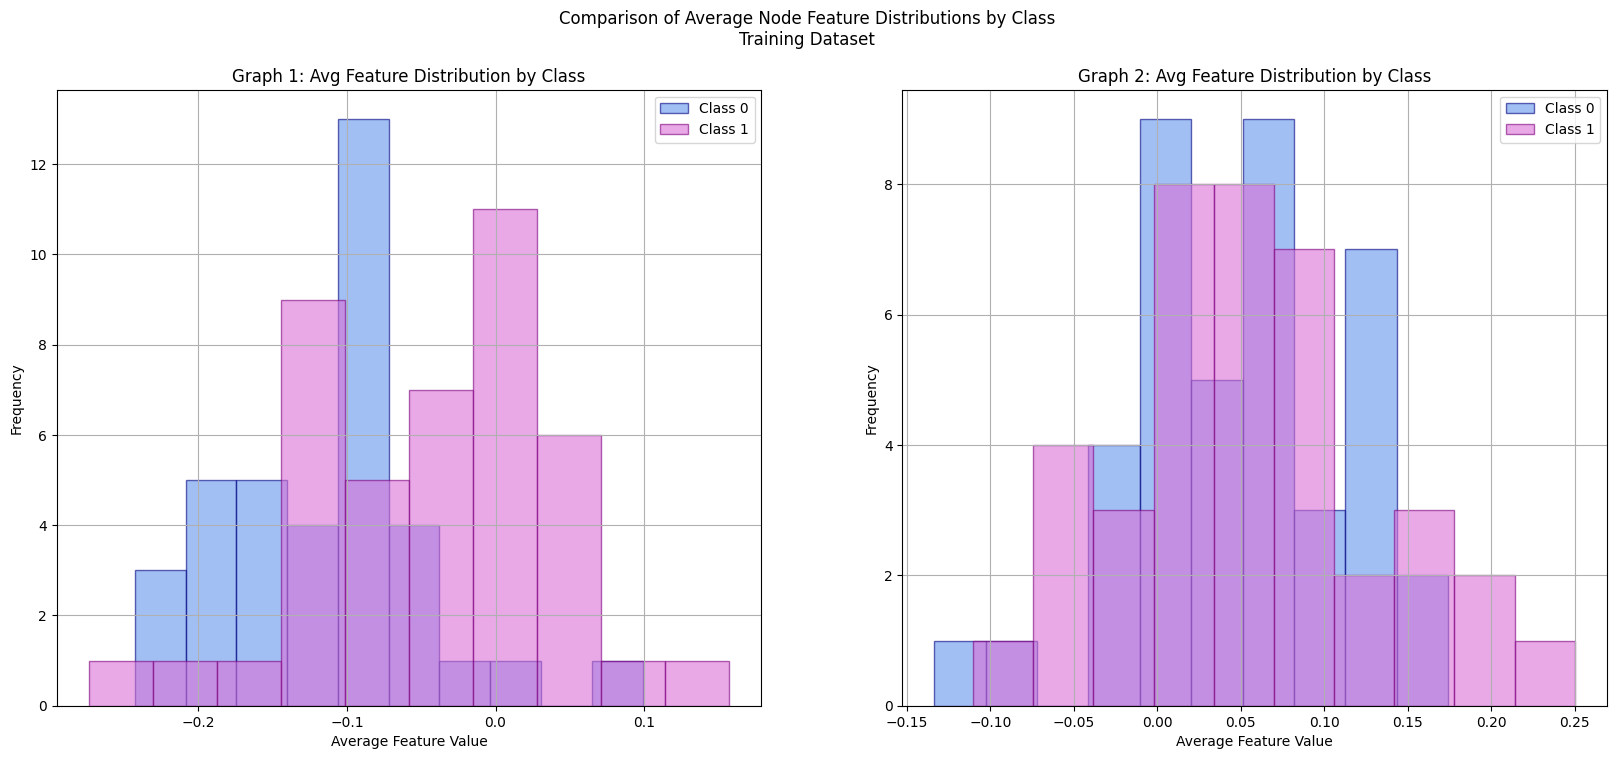

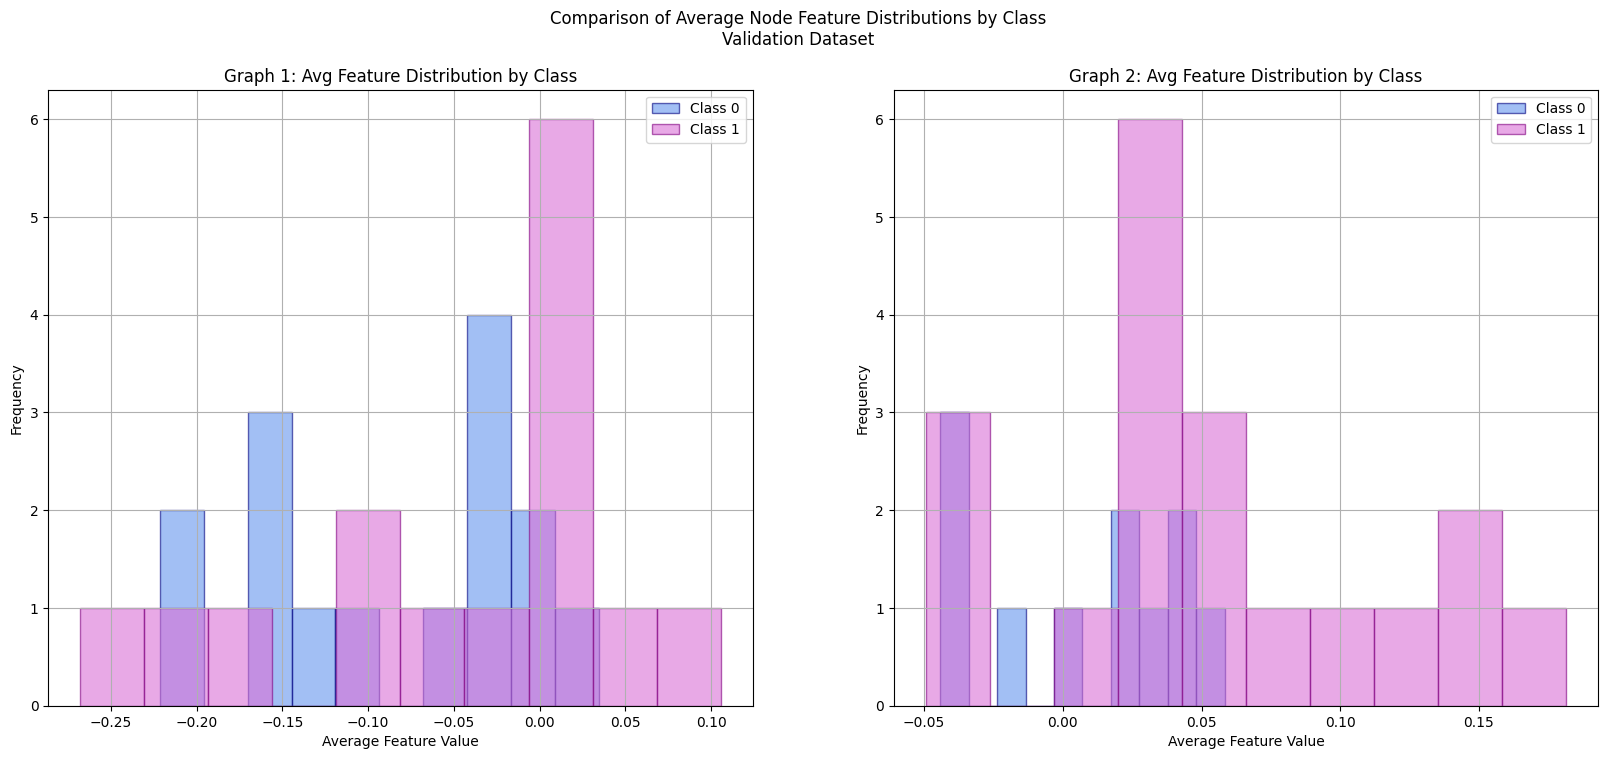

In [ ]:
plot_node_feature_dist_by_class_two_graphs(G1_train[0], G2_train[0], G1_train[2], G2_train[2], dataset_name='Training') #, save=True, plot_name="feature_dist_by_graph_training")
plot_node_feature_dist_by_class_two_graphs(G1_eval[0], G2_eval[0], G1_eval[2], G2_eval[2], dataset_name='Validation') #, save=True, plot_name="feature_dist_by_graph_eval")

## Question 3.2 -  Evaluating GCN Performance on Different Graph Structures


### Helper functions for normalising the A matrix.

In [10]:
# Helper function to normalise the A matrix
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


def patch_A_matrix(A):
    """Patches the A matrix"""
    A = A + torch.eye(A.size(0))
    A = symmetric_normalize(A)
    return A

def patch_A_for_dataset(dataset):
    """Patches the A matrix for a dataset (list)"""
    dataset = [ (X, patch_A_matrix(A), y) for X,A,y in dataset]
    return dataset

### Helper function for plotting training runs.

In [11]:
# Helper function for plotting:

def plot_training_and_validation(training_losses, validation_losses, graph1_label="Training Accuracy", graph2_label="Validation Accuracy", x_label="Epoch", title=None, save=False, plot_name=""):
    """
    Plots the validation accuracy and training loss over epochs.
    Args:
        validation_losses: List of validation accuracies (or losses)
        training_losses: List of training accuracies (or losses)
        aggregation: Aggregation method used (default: "mean")
    """
    plt.figure(figsize=(10, 6))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot training loss on the first y-axis
    epochs = range(1, len(training_losses) + 1)
    line1 = ax1.plot(epochs, training_losses, 'orchid', label=f'{graph1_label}')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(f'{graph1_label}', color='orchid')
    ax1.tick_params(axis='y', labelcolor='orchid')
    
    # Plot validation accuracy on the second y-axis
    line2 = ax2.plot(epochs, validation_losses, 'cornflowerblue', label=f'{graph2_label}')
    ax2.set_ylabel(f'{graph2_label}', color='cornflowerblue')
    ax2.tick_params(axis='y', labelcolor='cornflowerblue')
    
    # Add title and grid
    if not title:
        title = f'Training Accuracy and Validation Accuracy Over Time'
    plt.title(title)

    ax1.grid(True)
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    if save:
        fig_name = f"images/Q3/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

### Provided GCN Code

In [12]:
#Provided GCN Implementation
class GCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(GCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class GraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(GraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = GCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = GCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, **kwargs):
        # Pass through GCN layers
        A_normalized = patch_A_matrix(A)
        H1 = self.gcn1(X, A_normalized)
        H2 = self.gcn2(H1, A_normalized)  # Output shape: (num_nodes, 1)

        output = torch.sigmoid(H2)  # Sigmoid activation per node
        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if kwargs.get("return_embeddings", None):
            return output, (H1, H2)
        else:
            return output

### Helper functions for training GCN on a graph

In [13]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

def train_model(
    model,
    G_train,
    G_val,
    num_epochs=10,
    lr=0.0001,
    verbose=True,
    **kwargs,
):
    """
    Train the model, validate every 'validate_every' epochs, and pick the 
    checkpoint with best validation accuracy.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to train.
    G_train  = (X_train,A_train,y_train) : input
        the Graph 1
    Y_train = (X_val,A_val,y_val)
        the Graph 2
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for the optimizer.
    verbose: bool
        whether to display the loss, f1 and val_f1


    Returns:
    --------
    loss_history : list
        The training loss history across epochs.
    f1_train_history : list
        train F1s during training
    f1_val_history : list
        val F1s during training
    """
    X_train, A_train, y_train = G_train
    X_val, A_val, y_val = G_val

    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_history = []
    train_f1_history = []
    validation_f1_history = []

    for epoch in range(num_epochs):
        # A single Epoch training.
        # TRAINING
        model.train()
        optimizer.zero_grad()
        if kwargs.get("return_embeddings", None):
            out, train_embeddings = model(A_train, X_train, **kwargs)
        else:
            out = model(A_train, X_train, **kwargs)
        out = out.squeeze(-1)  # shape: (N,) if needed
        y_float = y_train.float()  # for BCE

        # Compute training loss
        loss = binary_cross_entropy(out, y_float)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Record training loss
        loss_value = loss.item()
        
        # EVALUATION
        loss_history.append(loss_value)
        train_prec, train_rec, train_f1 = evaluate_model(model, X_train, A_train, y_train)
        val_prec, val_rec, val_f1, eval_embeddings = evaluate_model(model,  X_val, A_val, y_val, return_embeddings=True)

        train_f1_history.append(train_f1)
        validation_f1_history.append(val_f1)                     
        # Evaluating the model
        if verbose:
            print(f"Epoch {epoch+1}, Training Loss: {loss_value}, Train F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}")
            
    if kwargs.get("return_embeddings", None):
        return loss_history, train_f1_history, validation_f1_history, train_embeddings, eval_embeddings
    else:
        return loss_history, train_f1_history, validation_f1_history


@torch.no_grad()
def evaluate_model(model, X,A,y, **kwargs):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """
    model.eval()
    if kwargs.get("return_embeddings", None):
        out, embeddings = model(A,X,**kwargs)  # shape: (N, 1)
    else:
        out = model(A,X,**kwargs)  # shape: (N, 1)
    out = out.squeeze(-1)  # shape: (N,)
    preds = (out >= 0.5).long()

    y_true = y.cpu().numpy()
    y_pred = preds.cpu().numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="micro")

    if kwargs.get("return_embeddings", None):
        return precision, recall, f1, embeddings
    return precision, recall, f1


### Q3.2.a - Implementation of Layered GCN


• Implement a GCN where layers can be passed as input parameter and that can return all
embedding layers. (If you will not be able to do so, to get results implement one class per
layer).

• Train the GCN on G1 and G2 independently. Plot your results. (Note: you don’t need to
get a high performance at this stage, just make sure it trains).

In [ ]:
# SOLUTION Q3.2.a
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

class GCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(GCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

# Adapted GCN Implementation
class LayeredGraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim, layers_num):
        super(LayeredGraphNeuralNetwork, self).__init__()   
        # Define GCN layers
        self.layers = nn.ModuleList()
        in_dim = input_dim
        out_dim = hidden_dim
        for _ in range(layers_num-1):
            self.layers.append(GCNLayer(in_dim, out_dim, True))
            in_dim = hidden_dim
        self.layers.append(GCNLayer(in_dim, 1, False))


    def forward(self, A, X, **kwargs):
        # Apply self-connections and normalize adjacency matrix
        A_normalized = patch_A_matrix(A)
        # Pass through all GCN layers
        H_k = X
        graph_embeddings = [] # store embeddings of every layer
        for layer in self.layers:
            H_k = layer(H_k, A_normalized)
            graph_embeddings.append(H_k)

        graph_output = torch.sigmoid(H_k)

        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)

        if kwargs.get("return_embeddings", None):
            return graph_output, graph_embeddings
        else:
            return graph_output

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Code to run the training and evaluation of the model with different number of layers.

Adapt it as needed.

LayeredGraphNeuralNetwork(
  (layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
)
Epoch 1, Training Loss: 0.7097499370574951, Train F1: 0.4625, Validation F1: 0.5000
Epoch 2, Training Loss: 0.7091735601425171, Train F1: 0.4625, Validation F1: 0.5000
Epoch 3, Training Loss: 0.7086026072502136, Train F1: 0.4625, Validation F1: 0.5000
Epoch 4, Training Loss: 0.7080375552177429, Train F1: 0.4500, Validation F1: 0.5000
Epoch 5, Training Loss: 0.7074790596961975, Train F1: 0.4375, Validation F1: 0.5000
Epoch 6, Training Loss: 0.7069272398948669, Train F1: 0.4375, Validation F1: 0.5000
Epoch 7, Training Loss: 0.706375777721405, Train F1: 0.4250, Validation F1: 0.5000
Epoch 8, Training Loss: 0.7058283090591431, Train F1: 0.4375, Validation F1: 0.5000
Epoch 9, Training Loss: 0.7052855491638184, Train F1: 0.4250, Validation F1: 0.5000
Epoch 10, Training Loss: 0.7047475576400757, Train F1: 0.4250, Validation F1: 0.5000
Epoch 11, Training Loss: 0.7042149305343628, Train F1: 0.3750, Validation F1:

<Figure size 1000x600 with 0 Axes>

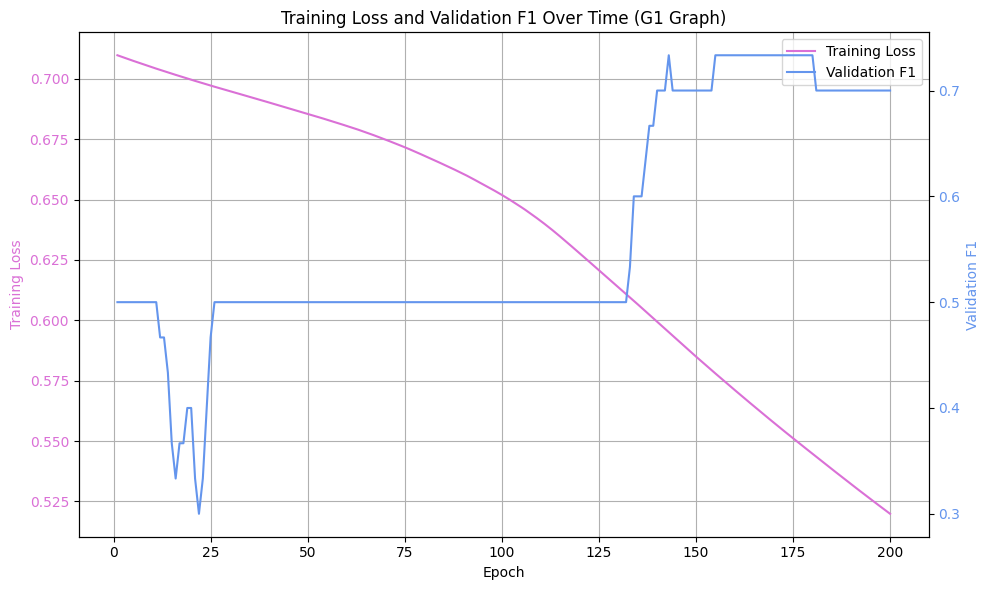

<Figure size 1000x600 with 0 Axes>

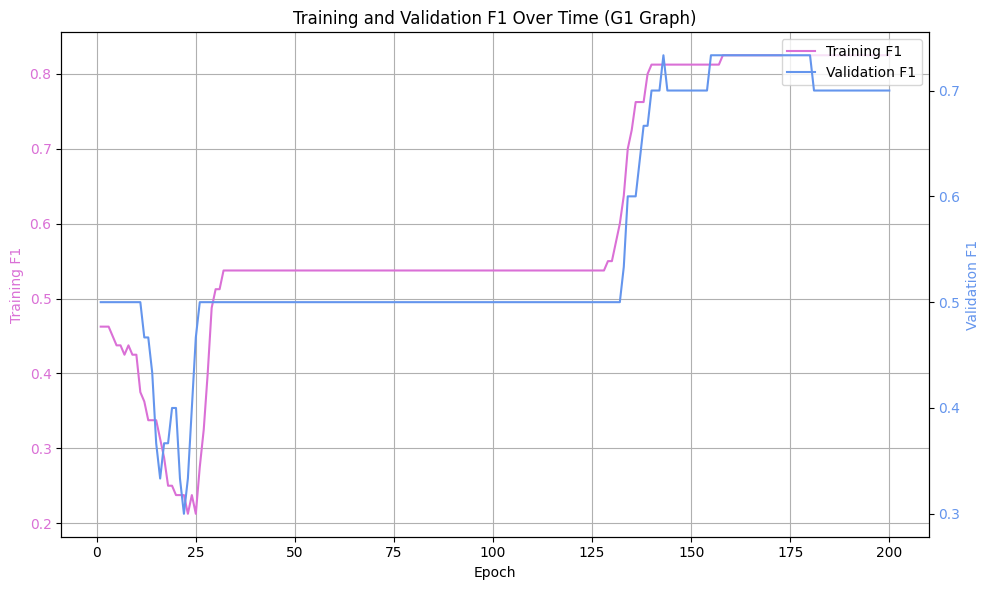

4


In [14]:

# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
layers_num = 4
model = LayeredGraphNeuralNetwork(input_dim, hidden_dim, layers_num=layers_num) 
print(model)

losses, train_f1, val_f1, train_embeddings, eval_embeddings = train_model(
    model,
    G1_train,
    G1_eval,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
    return_embeddings=True
)
plot_training_and_validation(losses, val_f1, graph1_label="Training Loss", graph2_label="Validation F1", x_label="Epoch", title="Training Loss and Validation F1 Over Time (G1 Graph)", save=False, plot_name="training_validation_f1")
plot_training_and_validation(train_f1, val_f1, graph1_label="Training F1", graph2_label="Validation F1", x_label="Epoch", title="Training and Validation F1 Over Time (G1 Graph)", save=False, plot_name="training_validation_f1")

print(len(train_embeddings))

### Q3.2.b - Plotting of t-SNE Embeddings for Graph Neural Networks

• Use t-SNE to visualize the node embeddings for the final layer of the GCN for each graph
for both training and evaluation data, use the labels as class labels for the tsne plot.

In [32]:
# SOLUTION Q3.5.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels=None, layer_to_plot=-1, colors=['cornflowerblue', 'orchid'], save=False, plot_name=""):
    """
    embeddings (list):
        list of embeddings (layer 2, ..., layer N)
        NOTE: for num_layer = 1 there is no embedding (as it is just the input)
    
    labels (list):
        list of labels
    
    layer_to_plot (int):
        which layer to plot (default -1, i.e. the last layer)
    """
    emb_to_plot = embeddings[layer_to_plot].detach().numpy()
    perplexity = emb_to_plot.shape[0] - 1
    embedding_tsne = TSNE(n_components=1, perplexity=perplexity).fit_transform(emb_to_plot)

    fig, ax = plt.subplots(figsize=(6, 6))
    x = np.arange(len(embedding_tsne))
    for node_class in np.unique(labels):
        label_node_idx = np.where(labels == node_class)
        ax.scatter(x[label_node_idx], embedding_tsne[label_node_idx], label=f'Class {node_class}', color=colors[node_class], alpha=0.7, s=150)
    ax.legend()

    title = f"TSNE plot of embeddings at layer {layer_to_plot+1}"
    if layer_to_plot == -1 or layer_to_plot == len(embeddings)-1:
        title = f"TSNE plot of embeddings at last layer ({len(embeddings)})"
    ax.set_title(title)
    if save:
        fig_name = f"images/Q3/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Plotting the t-SNE embeddings

Adapt as needed.

Created model with pre-defined Layers
LayeredGraphNeuralNetwork(
  (layers): ModuleList(
    (0-1): 2 x GCNLayer()
  )
)
Training on G1
Epoch 1, Training Loss: 0.7423171401023865, Train F1: 0.4625, Validation F1: 0.5000
Epoch 2, Training Loss: 0.7411746978759766, Train F1: 0.4625, Validation F1: 0.5000
Epoch 3, Training Loss: 0.740034282207489, Train F1: 0.4625, Validation F1: 0.5000
Epoch 4, Training Loss: 0.738899827003479, Train F1: 0.4625, Validation F1: 0.5000
Epoch 5, Training Loss: 0.7377699613571167, Train F1: 0.4625, Validation F1: 0.5000
Epoch 6, Training Loss: 0.7366462349891663, Train F1: 0.4625, Validation F1: 0.5000
Epoch 7, Training Loss: 0.7355273365974426, Train F1: 0.4625, Validation F1: 0.5000
Epoch 8, Training Loss: 0.7344163060188293, Train F1: 0.4625, Validation F1: 0.5000
Epoch 9, Training Loss: 0.7333046793937683, Train F1: 0.4625, Validation F1: 0.5000
Epoch 10, Training Loss: 0.7321934700012207, Train F1: 0.4625, Validation F1: 0.5000
Epoch 11, Training Loss: 

<Figure size 1000x600 with 0 Axes>

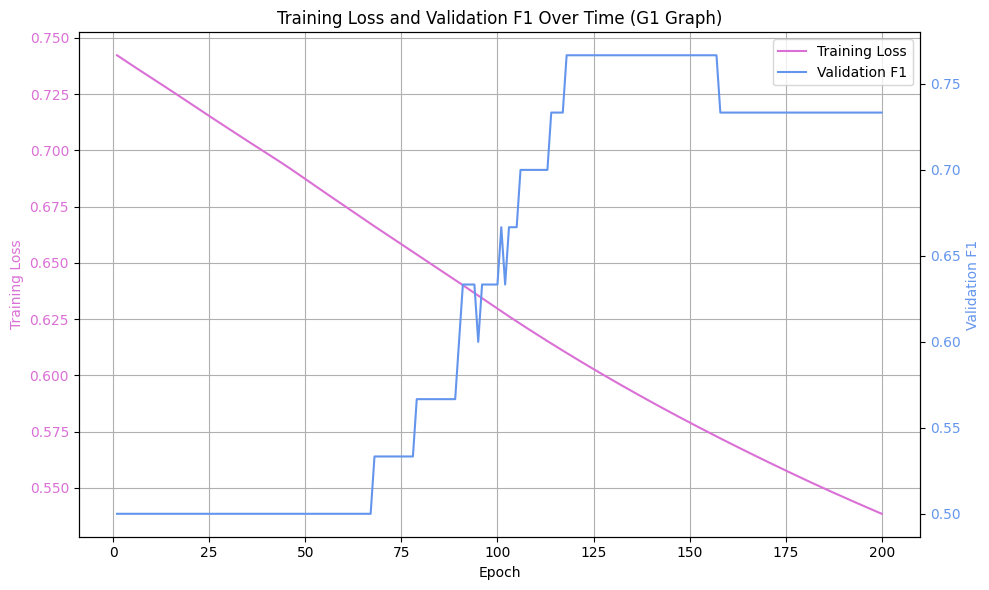

<Figure size 1000x600 with 0 Axes>

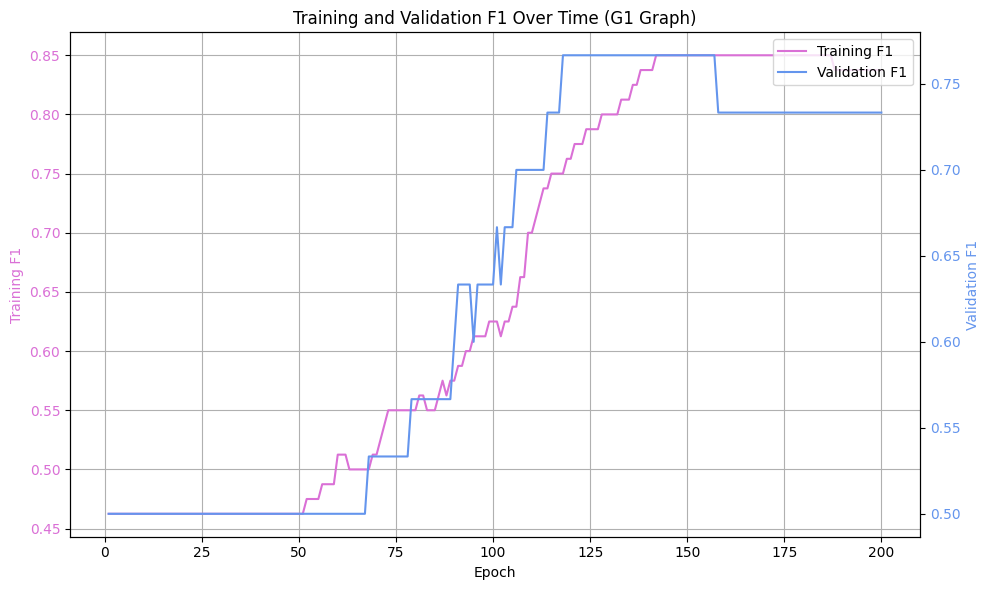

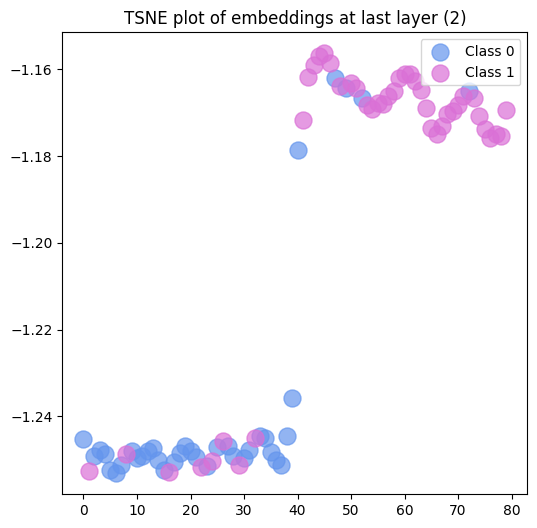

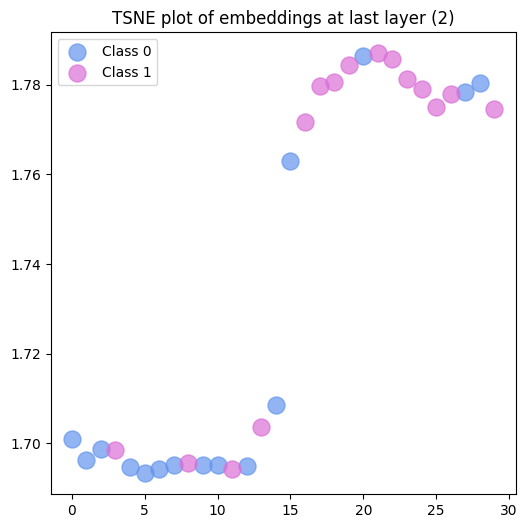


Training on G2
Epoch 1, Training Loss: 0.7092761993408203, Train F1: 0.5125, Validation F1: 0.3667
Epoch 2, Training Loss: 0.7088276147842407, Train F1: 0.5125, Validation F1: 0.3667
Epoch 3, Training Loss: 0.708381712436676, Train F1: 0.5125, Validation F1: 0.3667
Epoch 4, Training Loss: 0.7079384922981262, Train F1: 0.5125, Validation F1: 0.3667
Epoch 5, Training Loss: 0.7074981927871704, Train F1: 0.5125, Validation F1: 0.3667
Epoch 6, Training Loss: 0.7070606350898743, Train F1: 0.5125, Validation F1: 0.3667
Epoch 7, Training Loss: 0.7066260576248169, Train F1: 0.5125, Validation F1: 0.3667
Epoch 8, Training Loss: 0.7061944603919983, Train F1: 0.5125, Validation F1: 0.3667
Epoch 9, Training Loss: 0.7057657837867737, Train F1: 0.5125, Validation F1: 0.3667
Epoch 10, Training Loss: 0.7053400278091431, Train F1: 0.5125, Validation F1: 0.3667
Epoch 11, Training Loss: 0.7049172520637512, Train F1: 0.5125, Validation F1: 0.3667
Epoch 12, Training Loss: 0.7044976353645325, Train F1: 0.51

<Figure size 1000x600 with 0 Axes>

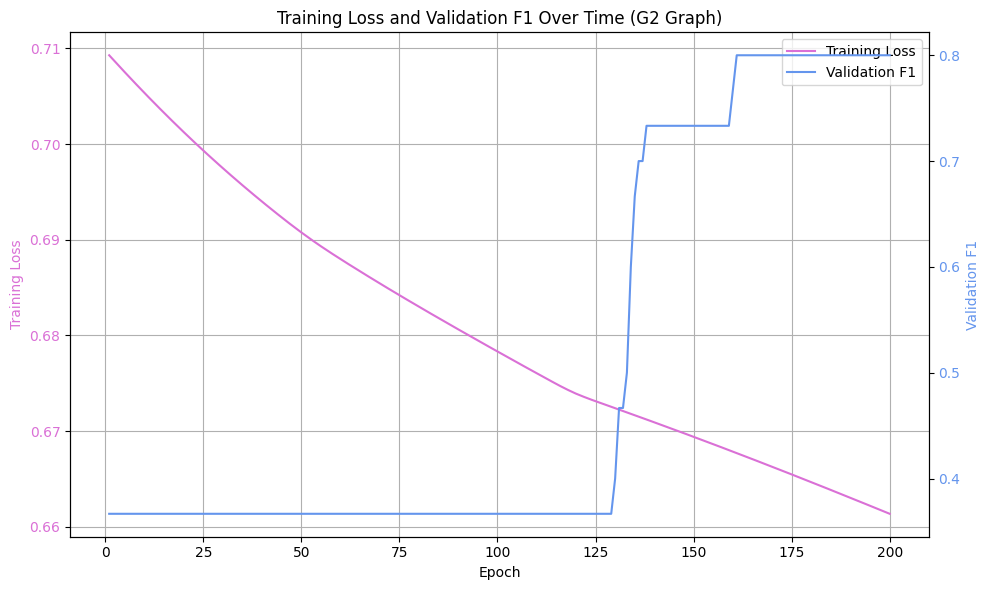

<Figure size 1000x600 with 0 Axes>

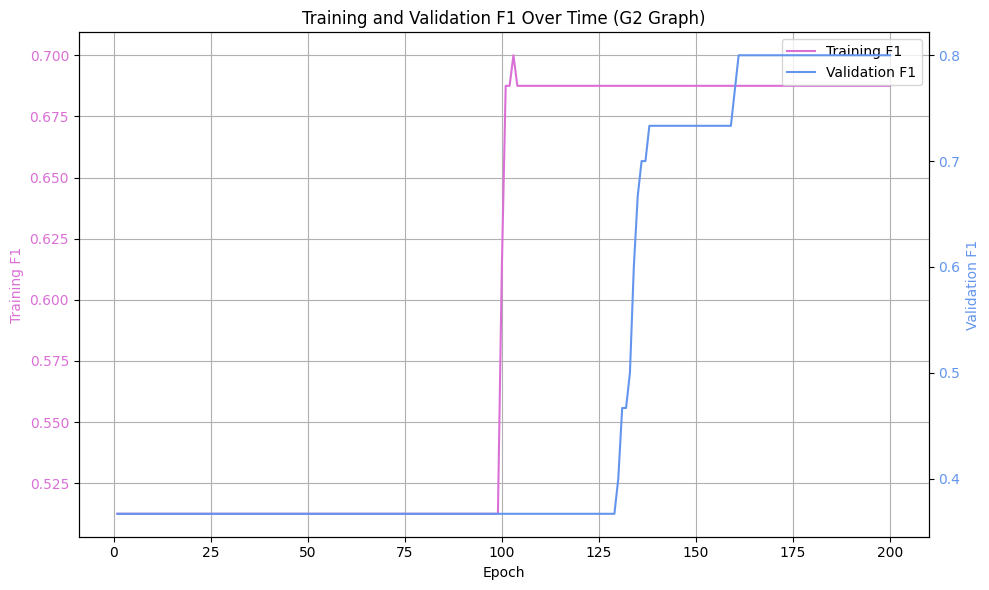

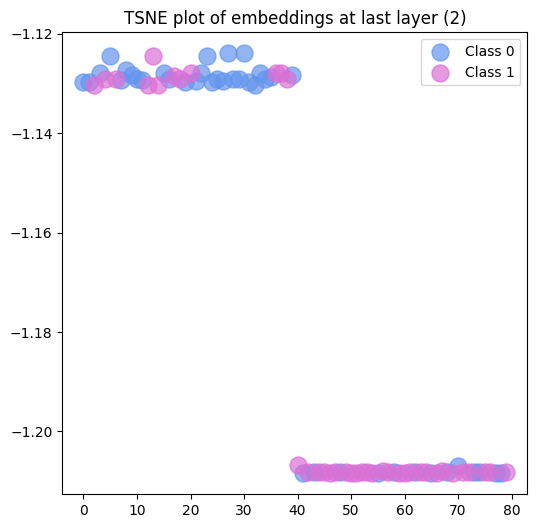

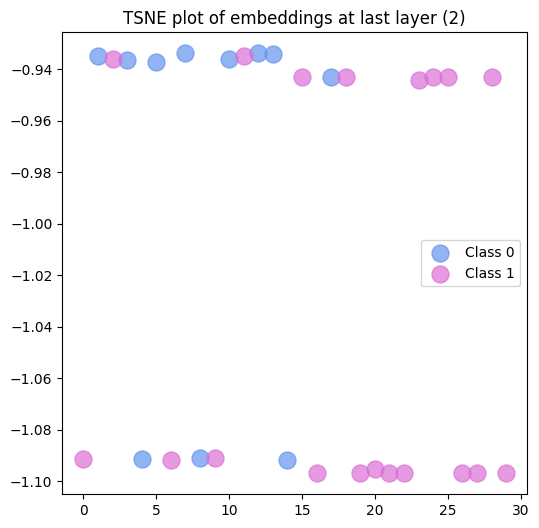

In [ ]:
# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
layers_num = 2


# Train on G1
model = LayeredGraphNeuralNetwork(input_dim, hidden_dim, layers_num=layers_num)
print("Created model with pre-defined Layers")
print(model)

print("Training on G1")
losses, train_f1, val_f1, train_embeddings, eval_embeddings = train_model(
    model,
    G1_train,
    G1_eval,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
    return_embeddings=True # NOTE we added this parameter
)
plot_training_and_validation(losses, val_f1, graph1_label="Training Loss", graph2_label="Validation F1", x_label="Epoch", title="Training Loss and Validation F1 Over Time (G1 Graph)") #, save=True, plot_name="G1_loss_layerGCN_f1")
plot_training_and_validation(train_f1, val_f1, graph1_label="Training F1", graph2_label="Validation F1", x_label="Epoch", title="Training and Validation F1 Over Time (G1 Graph)") #, save=True, plot_name="G1_f1_layerGCN_f1")

# print(len(last_embeddings))
plot_tsne(train_embeddings, G1_train[2]) #, save=True, plot_name=f"G1_train_tSNE_layer_{str(len(train_embeddings))}")
plot_tsne(eval_embeddings, G1_eval[2]) #, save=True, plot_name=f"G1_eval_tSNE_layer_{str(len(eval_embeddings))}")


# Train on G2
# reset model 
model = LayeredGraphNeuralNetwork(input_dim, hidden_dim, layers_num=layers_num)

print("\nTraining on G2")
losses, train_f1, val_f1, train_embeddings, eval_embeddings = train_model(
    model,
    G2_train,
    G2_eval,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
    return_embeddings=True # NOTE we added this parameter
)
plot_training_and_validation(losses, val_f1, graph1_label="Training Loss", graph2_label="Validation F1", x_label="Epoch", title="Training Loss and Validation F1 Over Time (G2 Graph)") #, save=True, plot_name="G2_loss_layerGCN_f1")
plot_training_and_validation(train_f1, val_f1, graph1_label="Training F1", graph2_label="Validation F1", x_label="Epoch", title="Training and Validation F1 Over Time (G2 Graph)") #, save=True, plot_name="G2_f1_layerGCN_f1")

# print(len(last_embeddings))
plot_tsne(train_embeddings, G2_train[2]) #, save=True, plot_name=f"G2_train_tSNE_layer_{str(len(train_embeddings))}")
plot_tsne(eval_embeddings, G2_eval[2]) #, save=True, plot_name=f"G2_eval_tSNE_layer_{str(len(eval_embeddings))}")


### Q3.2.c - Training the Model on Merged Graphs G = G1 ∪ G

• Implement a GCN that trains on both graphs at once. Plot the training curve.

• Compare the performance of G = G1 ∪ G2 against training on G1 and G2, respectively.

• Plot TSNE plots.

In [ ]:
# SOLUTION Q3.2.c
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

# Implement the training of G = {G1 U G2}
def merge_graphs(G1, G2):
    """
    Merges two graphs G1 and G2 into a single graph G by 
    concatenating the feature matrix, adjacency matrix 
    and labels vector.
    Params:
        - G1 (tuple): (X1, A1, y1) Graph 1 data
        - G2 (tuple): (X2, A2, y2) Graph 2 data
    Returns:
        - X (torch.Tensor): Merged feature matrix
        - A (torch.Tensor): Merged adjacency matrix
        - y (torch.Tensor): Merged labels vector
    """
    G = patch_A_for_dataset([G1, G2]) # list of [(X,A,y) for each graph]

    # Merge the features
    X = torch.cat((G[0][0], G[1][0]), dim=0)
    # Merge the labels
    y = torch.cat((G[0][2], G[1][2]), dim=0)

    # Merge and pad the adjacency matrices
    A1 = G[0][1]
    A2 = G[1][1]
    N1 = A1.size(0)
    A = torch.zeros((N1+A2.size(0), N1+A2.size(0)))
    A[:N1, :N1] = A1
    A[N1:, N1:] = A2

    return X, A, y

# In the end return a single function:
def train_G1UG2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, 
                lr=0.001, verbose=True, return_embeddings=True, num_layers=2):
    """
    Train the model on the merged graph G = {G1 U G2} for
    a given number of epochs.
    Params:
        - G1_train (tuple): (X1, A1, y1) Graph 1 training data
        - G1_eval (tuple): (X1, A1, y1) Graph 1 evaluation data
        - G2_train (tuple): (X2, A2, y2) Graph 2 training data
        - G2_eval (tuple): (X2, A2, y2) Graph 2 evaluation data
        - num_epochs (int): Number of training epochs
        - lr (float): Learning rate
        - verbose (bool): Whether to print training progress
        - return_embeddings (bool): Whether to return embeddings
        - num_layers (int): Number of GCN layers
    """
    # Initialising the model
    input_dim = 10
    hidden_dim = 8

    # merge the training and validation graphs
    G_train = merge_graphs(G1_train, G2_train)
    G_eval = merge_graphs(G1_eval, G2_eval)

    model = LayeredGraphNeuralNetwork(input_dim, hidden_dim, num_layers)
    print(model)
    
    # train the model
    losses, train_f1, val_f1, train_embeddings, eval_embeddings = train_model(
        model,
        G_train,
        G_eval,
        num_epochs=num_epochs,
        lr=lr,
        verbose=verbose,
        return_embeddings=return_embeddings
    )
    if return_embeddings:
        return losses, train_f1, val_f1, train_embeddings, eval_embeddings, G_train, G_eval
    return losses, train_f1, val_f1, G_train, G_eval

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Running the evaluation.

Training on G = {G1 U G2}
LayeredGraphNeuralNetwork(
  (layers): ModuleList(
    (0-1): 2 x GCNLayer()
  )
)
Epoch 1, Training Loss: 0.6925190687179565, Train F1: 0.5062, Validation F1: 0.5667
Epoch 2, Training Loss: 0.6911821961402893, Train F1: 0.5125, Validation F1: 0.5667
Epoch 3, Training Loss: 0.6898639798164368, Train F1: 0.5125, Validation F1: 0.5667
Epoch 4, Training Loss: 0.6885561943054199, Train F1: 0.5125, Validation F1: 0.5667
Epoch 5, Training Loss: 0.6872550249099731, Train F1: 0.5125, Validation F1: 0.5667
Epoch 6, Training Loss: 0.6859678626060486, Train F1: 0.5125, Validation F1: 0.5667
Epoch 7, Training Loss: 0.6846954226493835, Train F1: 0.5125, Validation F1: 0.5667
Epoch 8, Training Loss: 0.6834399104118347, Train F1: 0.5125, Validation F1: 0.5667
Epoch 9, Training Loss: 0.6822076439857483, Train F1: 0.5125, Validation F1: 0.5667
Epoch 10, Training Loss: 0.6809844970703125, Train F1: 0.5125, Validation F1: 0.5667
Epoch 11, Training Loss: 0.6797701120376587, Train

<Figure size 1000x600 with 0 Axes>

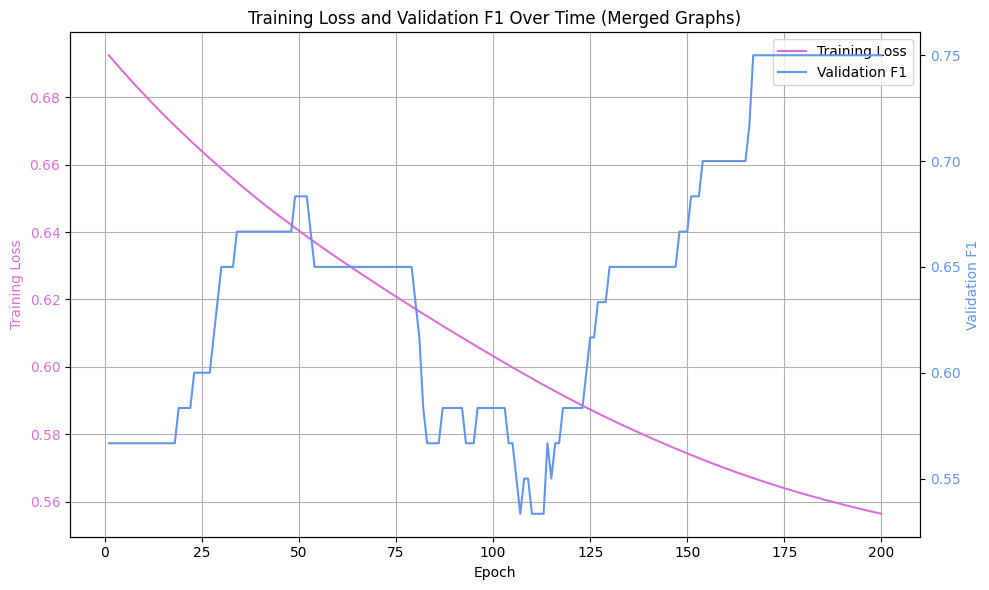

<Figure size 1000x600 with 0 Axes>

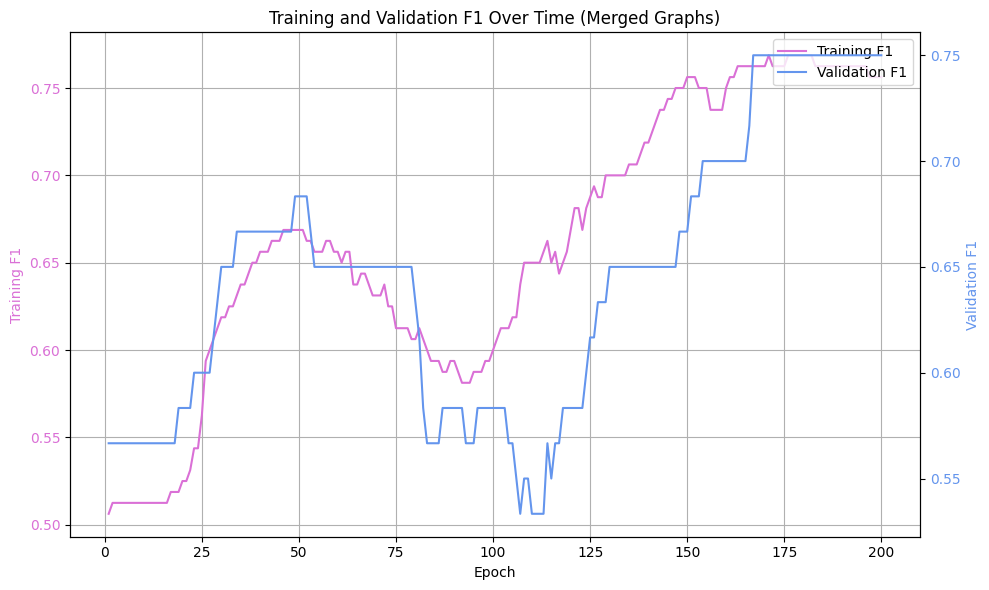

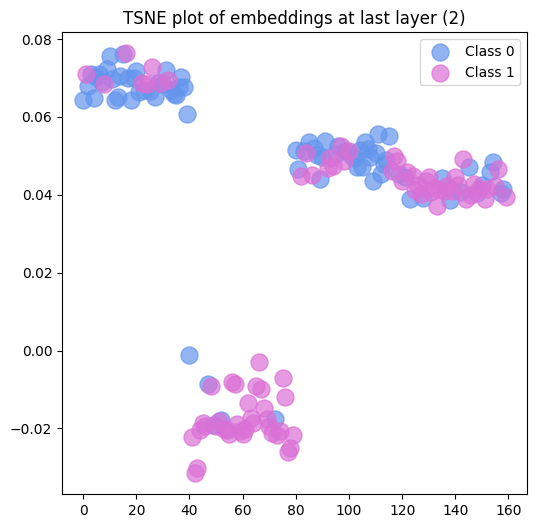

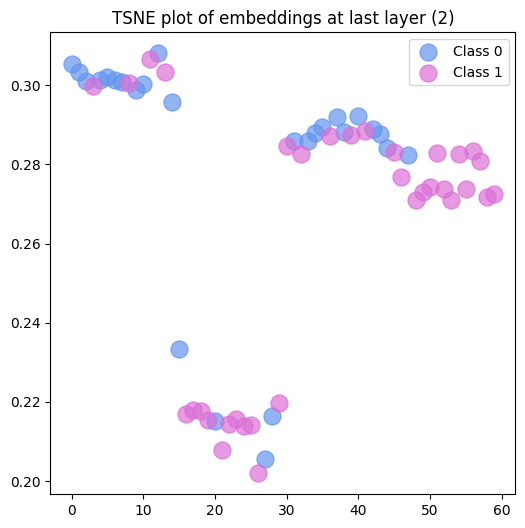

In [ ]:

# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

print("Training on G = {G1 U G2}")

losses, train_f1, val_f1, train_embeddings, eval_embeddings, G_train, G_eval = train_G1UG2(G1_train, G1_eval, G2_train, G2_eval, num_layers=2, num_epochs=200, lr=0.001, verbose=True, return_embeddings=True)

plot_training_and_validation(losses, val_f1, graph1_label="Training Loss", graph2_label="Validation F1", x_label="Epoch", title="Training Loss and Validation F1 Over Time (Merged Graphs)")#, save=True, plot_name="G1UG2_layerGCN_loss")
plot_training_and_validation(train_f1, val_f1, graph1_label="Training F1", graph2_label="Validation F1", x_label="Epoch", title="Training and Validation F1 Over Time (Merged Graphs)") #, save=True, plot_name="G1UG2_layerGCN_f1")

# print(len(last_embeddings))
plot_tsne(train_embeddings, G_train[2]) #, save=True, plot_name=f"G1UG2_train_tSNE_layer_{str(len(train_embeddings))}")
plot_tsne(eval_embeddings, G_eval[2]) #, save=True, plot_name=f"G1UG2_eval_tSNE_layer_{str(len(eval_embeddings))}")



### Q3.2.d Implement & discuss what you observe.

• Compare training results, embeddings, and overall observations between independent and
merged training.

• Formulate a hypothesis explaining your observations.

• Discuss different implementation options for training on both graphs, including your choice.
(e.g. what model modifications are possible; what training modifications are possible?)

• Provide relevant plots and tables where appropriate.

• Bonus: Implement a modification (or alternative approach) for training on G1 ∪ G2 and
compare outcomes.

In [ ]:
# SOLUTION Q3.2.d
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

# Implement the training of G = {G1 U G2}

# In the end return a single function:
# def train_G1UG2_v2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True):
#     """"""
#     # INSERT necessary things
#     return losses, train_f1, val_f1

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Runnning the evaluation. 

Note: It is optional to run this particular evaluation. You can modify it as needed.

In [ ]:

# Load data
# G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
# G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
# G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# losses, train_f1, val_f1 = train_G1UG2_v2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True)

# plot_training_and_validation(losses, val_f1)


## 3.3 Topological changes to improve training

### Q3.3.a - Plot the Ricci Curvature for each edge.

• Plot a barplot of the the Ricci curvature per edge, where the x-axis are the edges and y-axis
is the ricci curvature.

In [ ]:
# Plot curvature against edges
from graph_ricci_curvature import GraphRicciCurvature 

def plot_ricci_per_edge(A, color="cornflowerblue", dataset_name='Training', save=False, plot_name=""):
    """
    Plot the Ricci Curvature per edge in the graph, with the Ricci Curvature
    on the y-axis and the edge count on the x-axis.
    Params:
        -   A (torch.Tensor): Adjacency matrix of the graph
        -   color (str): color of the bars
        -   dataset_name (str): name of the dataset
        -   save (bool): whether to save the plot
        -   plot_name (str): name of the plot
    """
    G = nx.from_numpy_array(A.numpy())

    ricci_curvature = GraphRicciCurvature(G)
    curvatures_per_edge = ricci_curvature.compute_ricci_curvatures()

    # After computation, the Ricci curvature for each edge is stored in G[u][v]["ricciCurvature"]
    ricci_values = []
    edge_labels = []
    for (u, v), val in curvatures_per_edge.items():
        ricci_values.append(val)
        edge_labels.append((u, v))

    W, H = 15, 15
    if len(ricci_values) > 50:
        W, H = 30, 30
    plt.figure(figsize=(W, H))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar([i for i in range(len(ricci_values))], ricci_values, color=color, label="Graph 1", edgecolor='navy', alpha=0.6)
    ax.set_xticklabels(edge_labels)

    plt.grid(True, alpha=0.5)

    plt.xlabel('Edge')
    plt.ylabel('Ricci Curvature')
    plt.title(f'Comparison of Oliver-Ricci Curvature\n{dataset_name} Dataset')
    plt.legend()
    if save:
        fig_name = f"images/Q3/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

/var/folders/vr/t_3rc9l16fzfc__65h566qhw0000gn/T/ipykernel_90506/2832203588.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(edge_labels)


<Figure size 3000x3000 with 0 Axes>

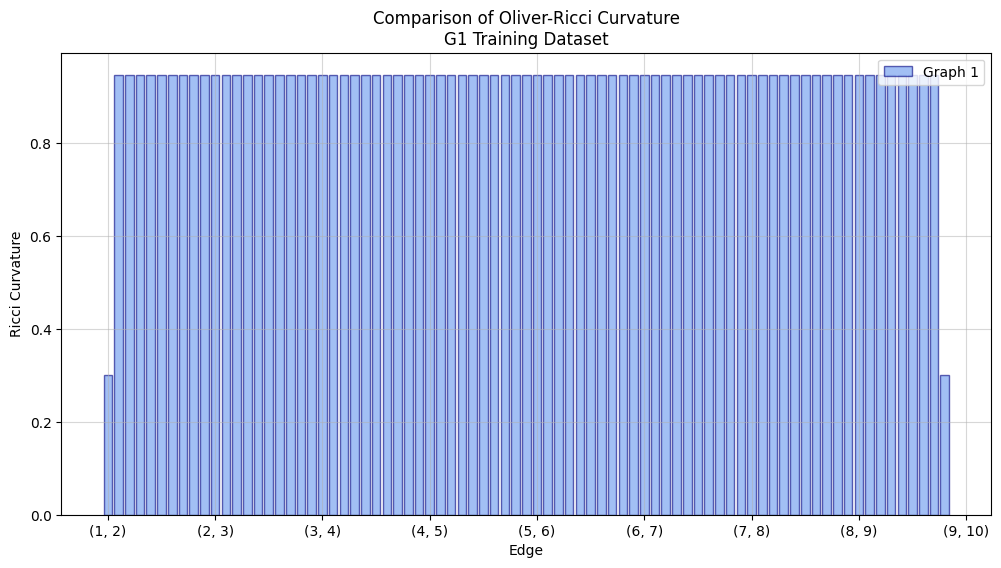

/var/folders/vr/t_3rc9l16fzfc__65h566qhw0000gn/T/ipykernel_90506/2832203588.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(edge_labels)


<Figure size 1500x1500 with 0 Axes>

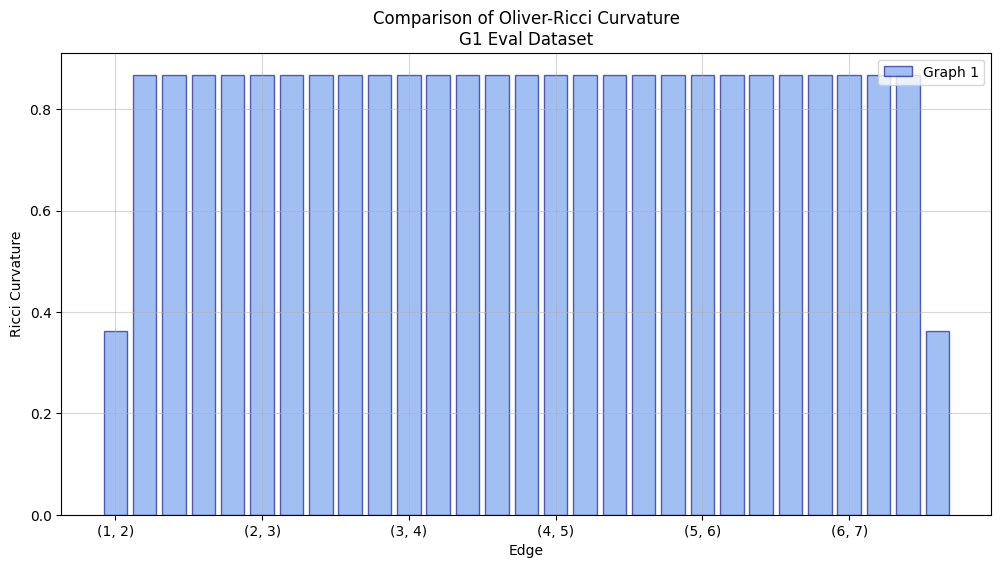

/var/folders/vr/t_3rc9l16fzfc__65h566qhw0000gn/T/ipykernel_90506/2832203588.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(edge_labels)


<Figure size 3000x3000 with 0 Axes>

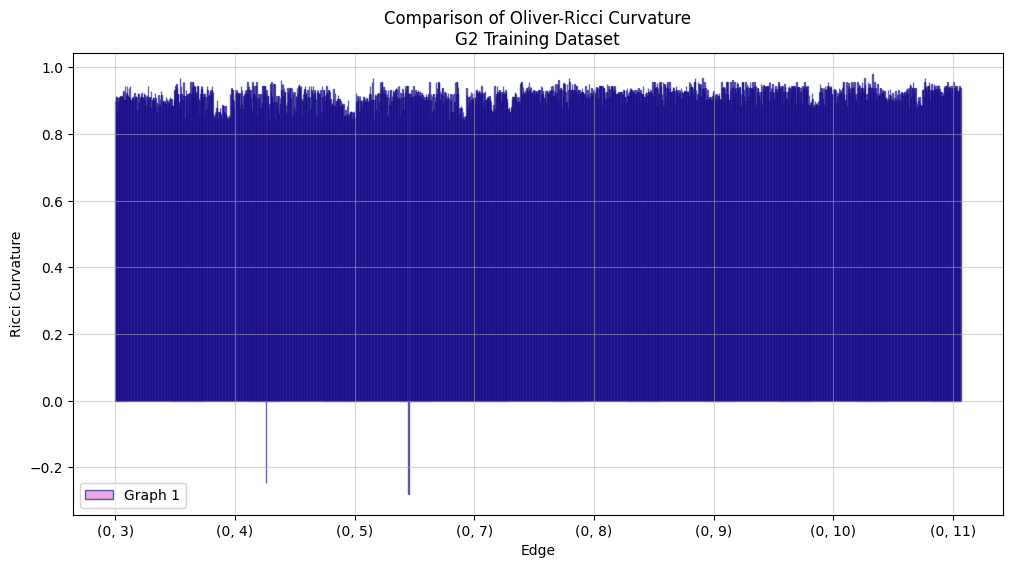

/var/folders/vr/t_3rc9l16fzfc__65h566qhw0000gn/T/ipykernel_90506/2832203588.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(edge_labels)


<Figure size 3000x3000 with 0 Axes>

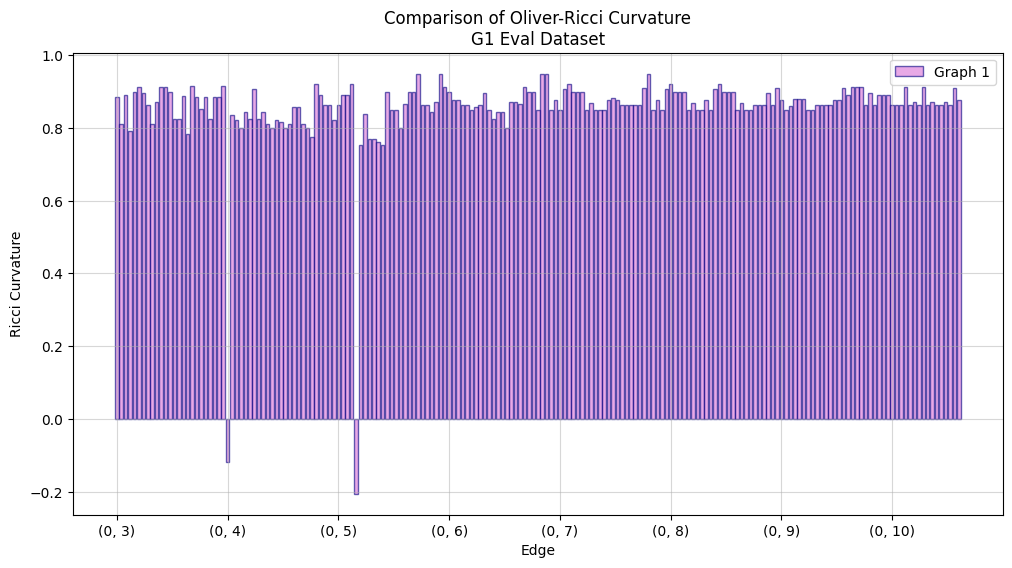

In [ ]:
# SOLUTION Q3.3.a
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label


plot_ricci_per_edge(G1_train[1], dataset_name='G1 Training', color='cornflowerblue') #, save=True, plot_name="ricci_per_edge_G1_training")
plot_ricci_per_edge(G1_eval[1], dataset_name='G1 Eval', color='cornflowerblue') #, save=True, plot_name="ricci_per_edge_G1_eval")
plot_ricci_per_edge(G2_train[1], dataset_name='G2 Training', color='orchid') #, save=True, plot_name="ricci_per_edge_G2_training")
plot_ricci_per_edge(G2_eval[1], dataset_name='G1 Eval', color='orchid') #, save=True, plot_name="ricci_per_edge_G2_eval")


# ####################################################
# END OF MODIFICATION
# ####################################################   

### Q3.3.b Investigate the extreme case topologies.

• How would you modify a topology so that the graph structure is ignored, making the GNN
behave like an MLP?

• What would an ideal graph structure be for optimal training and testing if labels were
available (both during training and testing)?

• What are you observations? Analyze the scores and what does it mean about the dataset?

• Provide relevant plots and results.

In [ ]:
# SOLUTION Q3.3.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def augment_graph_gold_labels(G):
    """
    Augment graph to return A that would be 'perfect', by only 
    connecting nodes with the same label (no self-connections).
    Params: 
        - G (tuple): (X,A,y) The Graph's feature matrix, 
                    adjacency matrix and labels
    Returns:
        - G (tuple): (X,A,y) The graph with the augmented 
                    adjacency matrix
    """
    X,A,y = G
    # connect only same-label nodes (with no self-connections)
    connections = [(i,j) for i in range(len(A)) for j in range(len(A)) if ((y[i] == y[j]) and (i != j))]
    augmented_A = torch.zeros_like(A)
    for i,j in connections:
        augmented_A[i,j] = 1
    return X,augmented_A,y

def augment_graph_no_effect(G):
    """Modify graph to return A that has no 'effect'"""
    X,A,y = G
    # identity matrix: no effect
    return X,torch.eye(A.size(0)),y

    
def improved_training(
        G_train,
        G_eval,
        model_params,
        num_epochs=200,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = {},
    ):
    """
    How can you improve the topologies to train better.
    """
    if change_topology_params["augmentation_strategy"] == "no_effect":
        augmentation_function = augment_graph_no_effect
    elif change_topology_params["augmentation_strategy"] == "gold":
        augmentation_function = augment_graph_gold_labels
    else:
        raise NotImplementedError("This augmentation setting is not implemented.")

    G_train = augmentation_function(G_train)
    G_train = G_train[0],symmetric_normalize(G_train[1]),G_train[2]

    G_eval = augmentation_function(G_eval)
    G_eval = G_eval[0],symmetric_normalize(G_eval[1]),G_eval[2]

    # Initialising the model
    model = LayeredGraphNeuralNetwork(**model_params)
    print(model)

    losses, train_f1, val_f1, train_embeddings, eval_embeddings = train_model(
        model,
        G_train,
        G_eval,
        num_epochs=num_epochs,
        lr=lr,
        verbose=verbose,
        return_embeddings = return_embeddings
    )
    return losses, train_f1, val_f1, train_embeddings, eval_embeddings

# ####################################################
# END OF MODIFICATION
# ####################################################  


### Code to run improvement
Note: run it a few times to see what performance can be reached on the eval dataset.

---------------- Augumentation Strategy: gold ----------------
LayeredGraphNeuralNetwork(
  (layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
)
Epoch 1, Training Loss: 0.7015641927719116, Train F1: 0.4875, Validation F1: 0.6333
Epoch 2, Training Loss: 0.7006281614303589, Train F1: 0.4875, Validation F1: 0.6333
Epoch 3, Training Loss: 0.6997538805007935, Train F1: 0.4875, Validation F1: 0.6333
Epoch 4, Training Loss: 0.6989491581916809, Train F1: 0.4875, Validation F1: 0.6333
Epoch 5, Training Loss: 0.6981934309005737, Train F1: 0.4875, Validation F1: 0.6333
Epoch 6, Training Loss: 0.6975106000900269, Train F1: 0.4875, Validation F1: 0.6333
Epoch 7, Training Loss: 0.6968420743942261, Train F1: 0.4875, Validation F1: 0.6333
Epoch 8, Training Loss: 0.6962445378303528, Train F1: 0.4875, Validation F1: 0.6333
Epoch 9, Training Loss: 0.6957420110702515, Train F1: 0.4875, Validation F1: 0.6333
Epoch 10, Training Loss: 0.6953145861625671, Train F1: 0.4875, Validation F1: 0.6333
Epoch 11, Tra

<Figure size 1000x600 with 0 Axes>

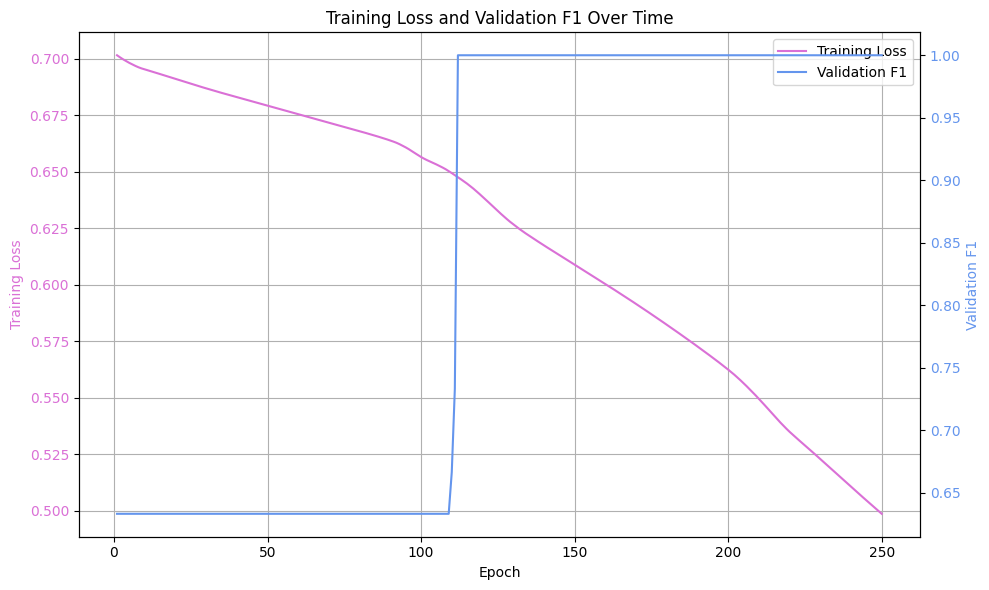

<Figure size 1000x600 with 0 Axes>

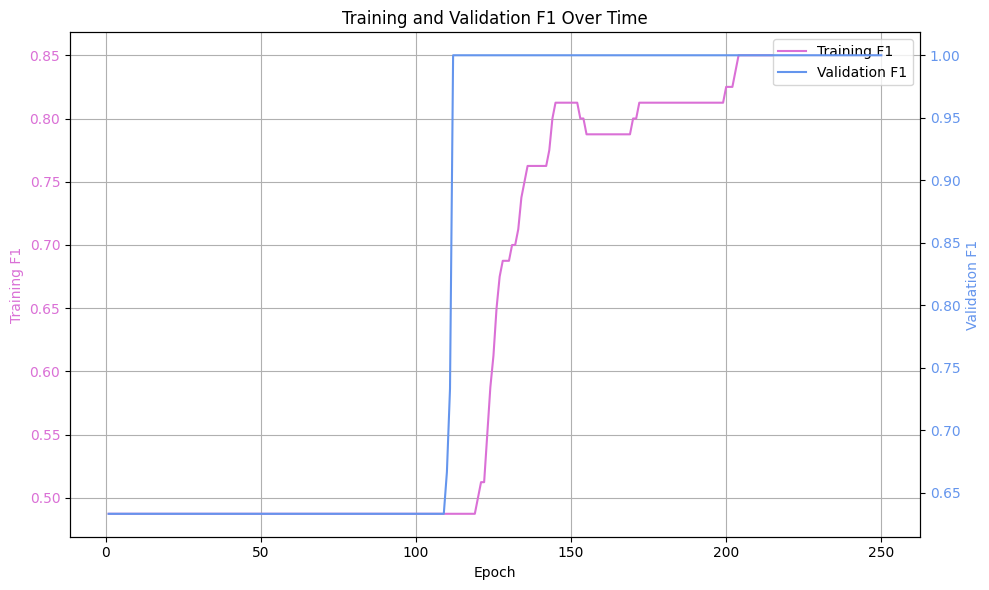

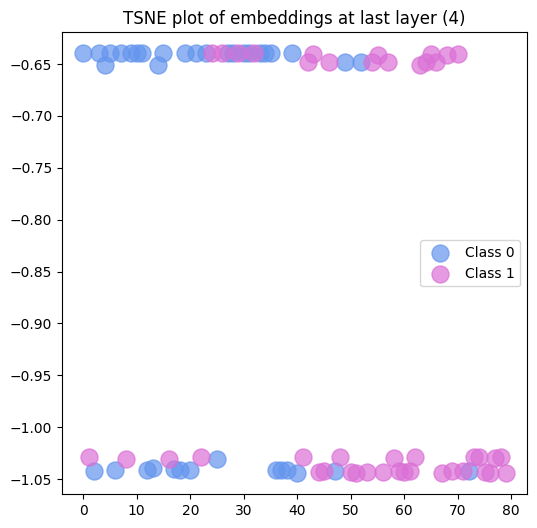

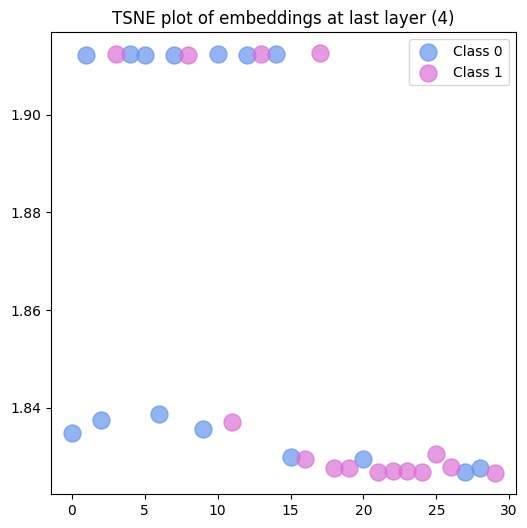

---------------- Augumentation Strategy: no_effect ----------------
LayeredGraphNeuralNetwork(
  (layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
)
Epoch 1, Training Loss: 0.6933899521827698, Train F1: 0.5500, Validation F1: 0.4000
Epoch 2, Training Loss: 0.6932640671730042, Train F1: 0.5500, Validation F1: 0.4000
Epoch 3, Training Loss: 0.6931384801864624, Train F1: 0.5375, Validation F1: 0.4000
Epoch 4, Training Loss: 0.693015456199646, Train F1: 0.5375, Validation F1: 0.4000
Epoch 5, Training Loss: 0.6928930282592773, Train F1: 0.5375, Validation F1: 0.4000
Epoch 6, Training Loss: 0.6927666068077087, Train F1: 0.5375, Validation F1: 0.4000
Epoch 7, Training Loss: 0.6926408410072327, Train F1: 0.5375, Validation F1: 0.4000
Epoch 8, Training Loss: 0.6925212144851685, Train F1: 0.5375, Validation F1: 0.4000
Epoch 9, Training Loss: 0.6924033761024475, Train F1: 0.5375, Validation F1: 0.4333
Epoch 10, Training Loss: 0.6922901272773743, Train F1: 0.5500, Validation F1: 0.4333
Epoch 11,

<Figure size 1000x600 with 0 Axes>

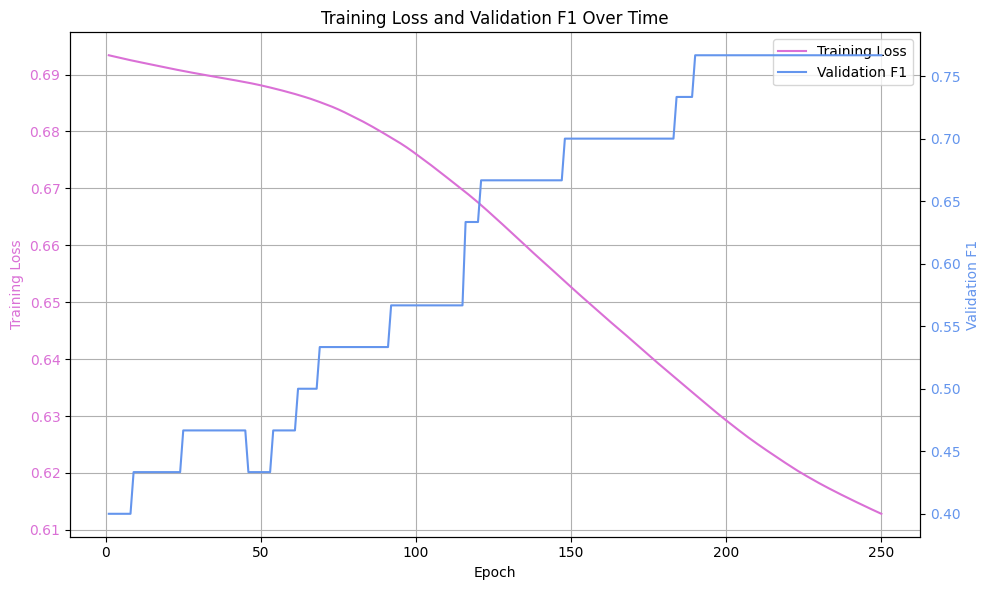

<Figure size 1000x600 with 0 Axes>

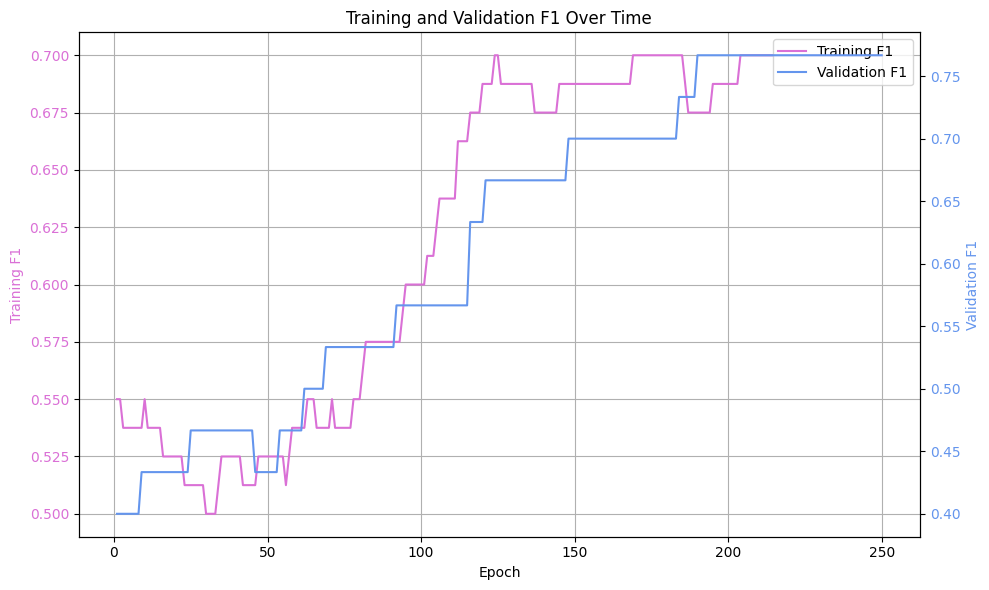

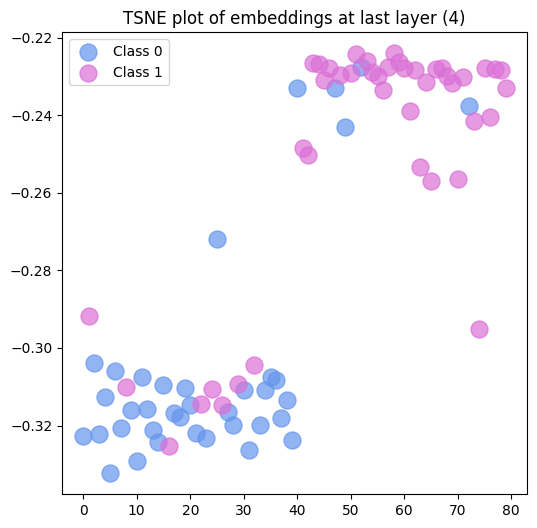

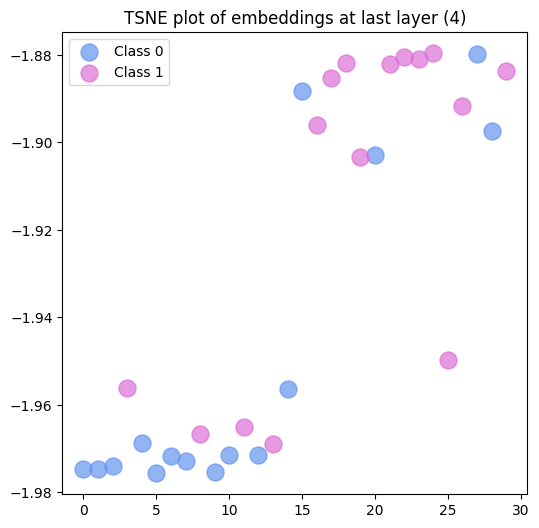

In [ ]:
# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

model_params = {    
    "input_dim":10, 
    "hidden_dim":8,
    "layers_num":4,
}

change_topology_params_no_effect = {
    "augmentation_strategy":"no_effect",
    "normalise" : False,
}

change_topology_params_gold = {
    "augmentation_strategy":"gold",
    "normalise" : True,
}

topology_params = [change_topology_params_gold, change_topology_params_no_effect]

for param in topology_params:
    print(f"---------------- Augumentation Strategy: {param['augmentation_strategy']} ----------------")
    losses, train_f1, val_f1, train_embeddings, eval_embeddings = improved_training(
        G2_train,
        G2_eval,
        model_params=model_params,
        num_epochs=250,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = param, #change as needed
    )
    # plot_training_and_validation(losses, val_f1)
    _,_,y_train = G1_train
    _, _, y_eval = G1_eval
    # print(len(train_embeddings))
    # plot_tsne(train_embeddings, y)


    plot_training_and_validation(losses, val_f1, graph1_label="Training Loss", graph2_label="Validation F1", x_label="Epoch", title="Training Loss and Validation F1 Over Time") #, save=True, plot_name=f"{param['augmentation_strategy']}_layerGCN_loss")
    plot_training_and_validation(train_f1, val_f1, graph1_label="Training F1", graph2_label="Validation F1", x_label="Epoch", title="Training and Validation F1 Over Time") #, save=True, plot_name=f"{param['augmentation_strategy']}_layerGCN_f1")
    plot_tsne(train_embeddings, y_train) #, save=True, plot_name=f"{param['augmentation_strategy']}_train_tSNE")
    plot_tsne(eval_embeddings, y_eval) #, save=True, plot_name=f"{param['augmentation_strategy']}_eval_tSNE")


### Q3.3.C Improving Graph Topology for Better Learning

• Implement two graph modifications.

• Describe your modifications.

• What motivated your implementation?

• If it helped give a hypothesis on why you think that is? If it did not give a hypothesis why
you think it did not help.

• Provide relevant plots and results

In [ ]:
# # SOLUTION Q3.3.c
# # ####################################################
# # MODIFY THE CODE BELOW 
# # ####################################################  

# def augment_graph(G):
#     """Augments the graph."""
#     X,A,y = G

#     # add self connections and normalize
#     A = patch_A_matrix(A)

#     return X,A,y
    
# def improved_training(
#         G_train,
#         G_eval,
#         model_params,
#         num_epochs=200,
#         lr=0.0005,
#         verbose=True,
#         return_embeddings = True,
#         change_topology_params = {},
#     ):
#     """
#     How can you improve the topologies to train better.
#     """

#     G_train = augment_graph(G_train)
#     G_train = G_train[0],symmetric_normalize(G_train[1]),G_train[2]

#     G_eval = augment_graph(G_eval)
#     G_eval = G_eval[0],symmetric_normalize(G_eval[1]),G_eval[2]

#     # Initialising the model
#     model = LayeredGraphNeuralNetwork(**model_params)
#     print(model)

#     losses, train_f1, val_f1, last_embeddings = train_model(
#         model,
#         G_train,
#         G_eval,
#         num_epochs=num_epochs,
#         lr=lr,
#         verbose=verbose,
#         return_embeddings = True
#     )
#     return losses, train_f1, val_f1, last_embeddings

# # ####################################################
# # END OF MODIFICATION
# # ####################################################  

### Code to run improvement

In [ ]:
# # Load data
# G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
# G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
# G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label


# model_params = {    
#     "input_dim":10, 
#     "hidden_dim":8,
#     "num_layers":4,
# }

# change_topology_params_eval = {
#     "augmentation_strategy":"eval",
# }

# topology_params = [change_topology_params_eval]

# for param in topology_params:
#     print(f"---------------- Augumentation Strategy: {param['augmentation_strategy']} ----------------")

#     losses, train_f1, val_f1, train_embeddings, eval_embeddings = improved_training(
#         G2_train,
#         G2_eval,
#         model_params=model_params,
#         num_epochs=200,
#         lr=0.0005,
#         verbose=True,
#         return_embeddings = True,
#         change_topology_params = param #change as needed
#     )
#     # plot_training_and_validation(losses, val_f1)

#     _,_,y_train = G1_train
#     _, _, y_eval = G1_eval
#     # print(len(last_embeddings))
#     # plot_tsne(last_embeddings, y_train)

#     plot_training_and_validation(losses, val_f1, graph1_label="Training Loss", graph2_label="Validation F1", x_label="Epoch", title="Training Loss and Validation F1 Over Time") #, save=True, plot_name=f"{param['augmentation_strategy']}_layerGCN_loss")
#     plot_training_and_validation(train_f1, val_f1, graph1_label="Training F1", graph2_label="Validation F1", x_label="Epoch", title="Training and Validation F1 Over Time") #, save=True, plot_name=f"{param['augmentation_strategy']}_layerGCN_f1")
#     plot_tsne(train_embeddings, y_train) #, save=True, plot_name=f"{param['augmentation_strategy']}_train_tSNE")
#     plot_tsne(eval_embeddings, y_eval) #, save=True, plot_name=f"{param['augmentation_strategy']}_eval_tSNE")
